In [75]:
%matplotlib inline
from read_yse_ztf_snana_dir import read_YSE_ZTF_snana_dir
from matplotlib.backends.backend_pdf import PdfPages


import glob
import sncosmo
import light_curve
from light_curve import VillarFit
import extinction
from extinction import fm07, apply, remove
import statistics as st

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'

# Load fakes (sims) DF and DR4 DF

In [76]:
import os
os.getcwd()

'/Users/sammysharief/Downloads/PGM-Project/Notebooks'

In [77]:
fakes_df = pd.read_csv("../SNIa_sims.csv", index_col=0) #Might need to update if you are using SNIa sims
dr4_df = pd.read_csv("../Real_Data.csv", index_col=0)

In [78]:
dr4_df

,X_villar_fit_amplitude,X_villar_fit_baseline,X_villar_fit_peak_time,X_villar_fit_rise_time,X_villar_fit_fall_time,X_villar_fit_plateau_slope,X_villar_fit_plateau_duration,X_villar_fit_reduced_chi2,Y_villar_fit_amplitude,Y_villar_fit_baseline,Y_villar_fit_peak_time,Y_villar_fit_rise_time,Y_villar_fit_fall_time,Y_villar_fit_plateau_slope,Y_villar_fit_plateau_duration,Y_villar_fit_reduced_chi2
ObjectID,,,,,,,,,,,,,,,,
2019pmd,16043.170096,505.291090,58732.791269,2.508347,12.665018,0.000031,15.144575,3.751819,32636.145948,310.297876,58734.711106,3.740048,27.311537,0.767218,38.735444,7.057182
2019tvv,38237.061189,255.905918,58786.492228,0.057817,48.171424,0.914855,20.931697,18.728311,46178.752357,105.385412,58783.799939,6.448905,31.999355,0.795001,18.588740,2.105791
2019wka,30479.828624,964.512361,58842.165228,9.562078,8.562046,0.251615,2.875893,0.952788,31584.261109,-861.290218,58829.143656,163.779304,31.462784,0.000006,8.833172,8.842830
2019wqf,3816.718679,355.947450,58859.236505,48.569658,27.501734,0.003912,0.010538,3.870026,20423.021178,247.998101,58819.389049,15.601124,26.241853,0.019049,16.103958,7.509673
2019wyp,11640.985426,242.518470,58463.325546,164.853240,10.280965,0.729418,379.862028,1.662041,10846.930227,-660.444802,58807.173779,458.981778,94.645454,0.755129,69.052086,0.553567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021xjh,519.127274,320.380605,59467.200119,2.968587,11.648718,0.623503,2.847938,0.084919,497.184416,210.229085,59454.296941,3.628357,31.231477,0.000020,8.441260,1.088728
2021xkm,18958.374036,-943.416219,59465.443069,2.881253,66.072748,0.861141,25.479874,0.615417,15363.598701,-522.971251,59464.708608,2.808642,33.823828,0.716136,29.707319,2.086839
2021yab,880.383091,747.541269,59460.409536,0.127961,3.240352,0.146037,8.015195,1.742510,1929.253349,357.826235,59459.704366,2.460885,255.021310,1.000000,38.858197,1.299094


In [79]:
fakes_df = fakes_df.drop(['X_villar_fit_peak_time', 'Y_villar_fit_peak_time'], axis=1)
dr4_df = dr4_df.drop(['X_villar_fit_peak_time', 'Y_villar_fit_peak_time'], axis=1)

In [80]:
fakes_df = fakes_df.dropna()
dr4_df = dr4_df.dropna()

In [81]:
#fakes_df.to_csv("../Tables/simulated_df_villar_params.csv.gzip", compression='gzip')
# fakes_df

In [82]:
#dr4_df.to_csv("../Tables/real_data_df_villar_params.csv.gzip", compression='gzip')
# dr4_df

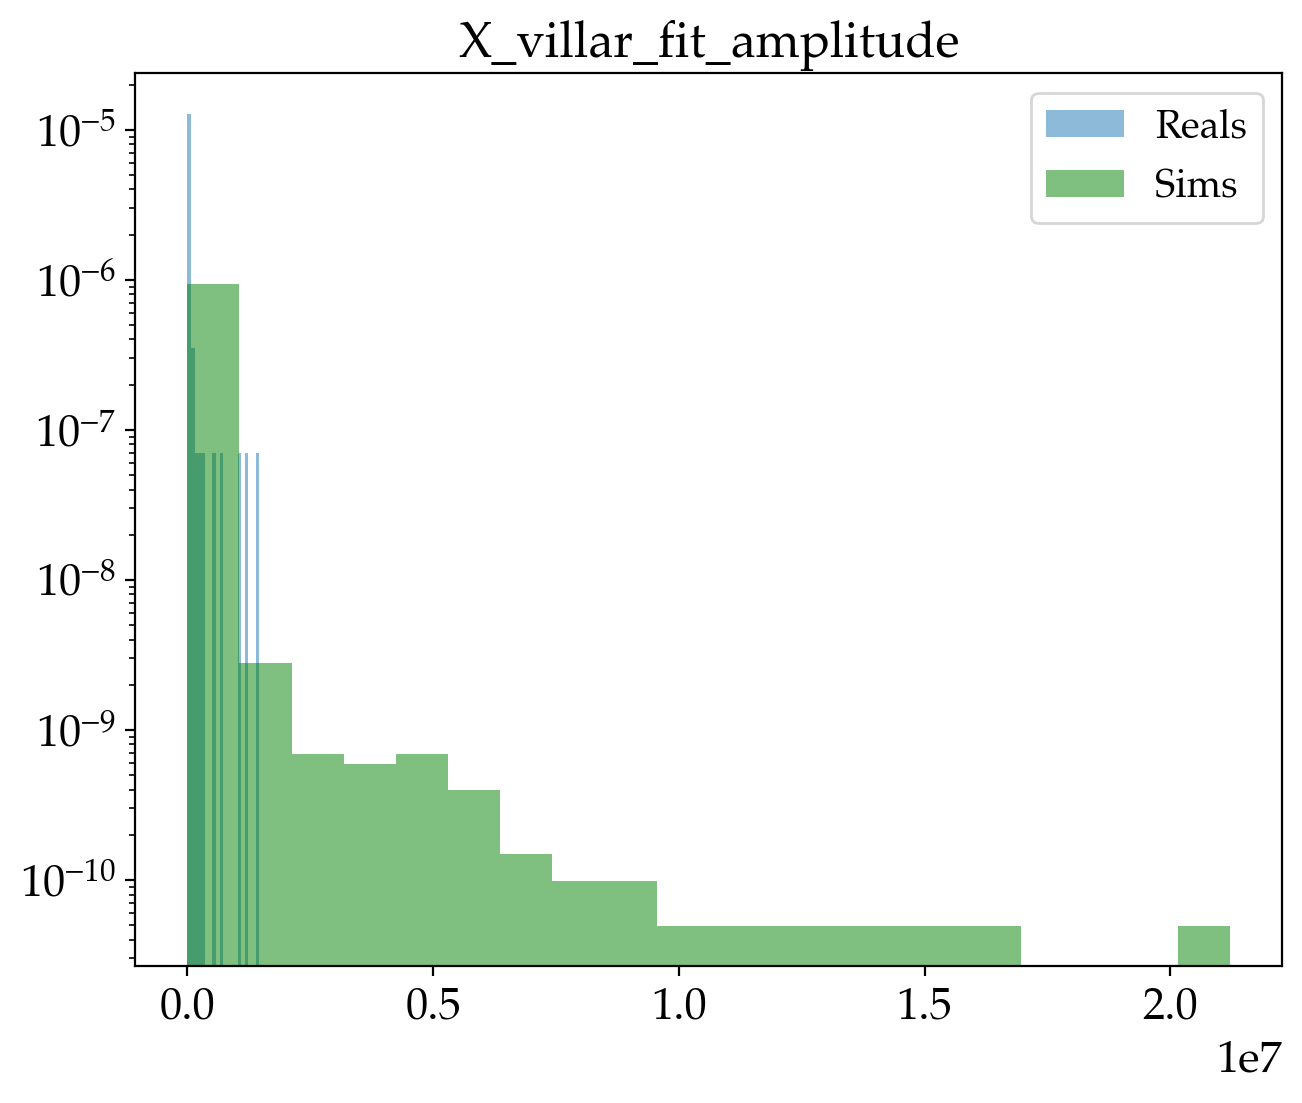

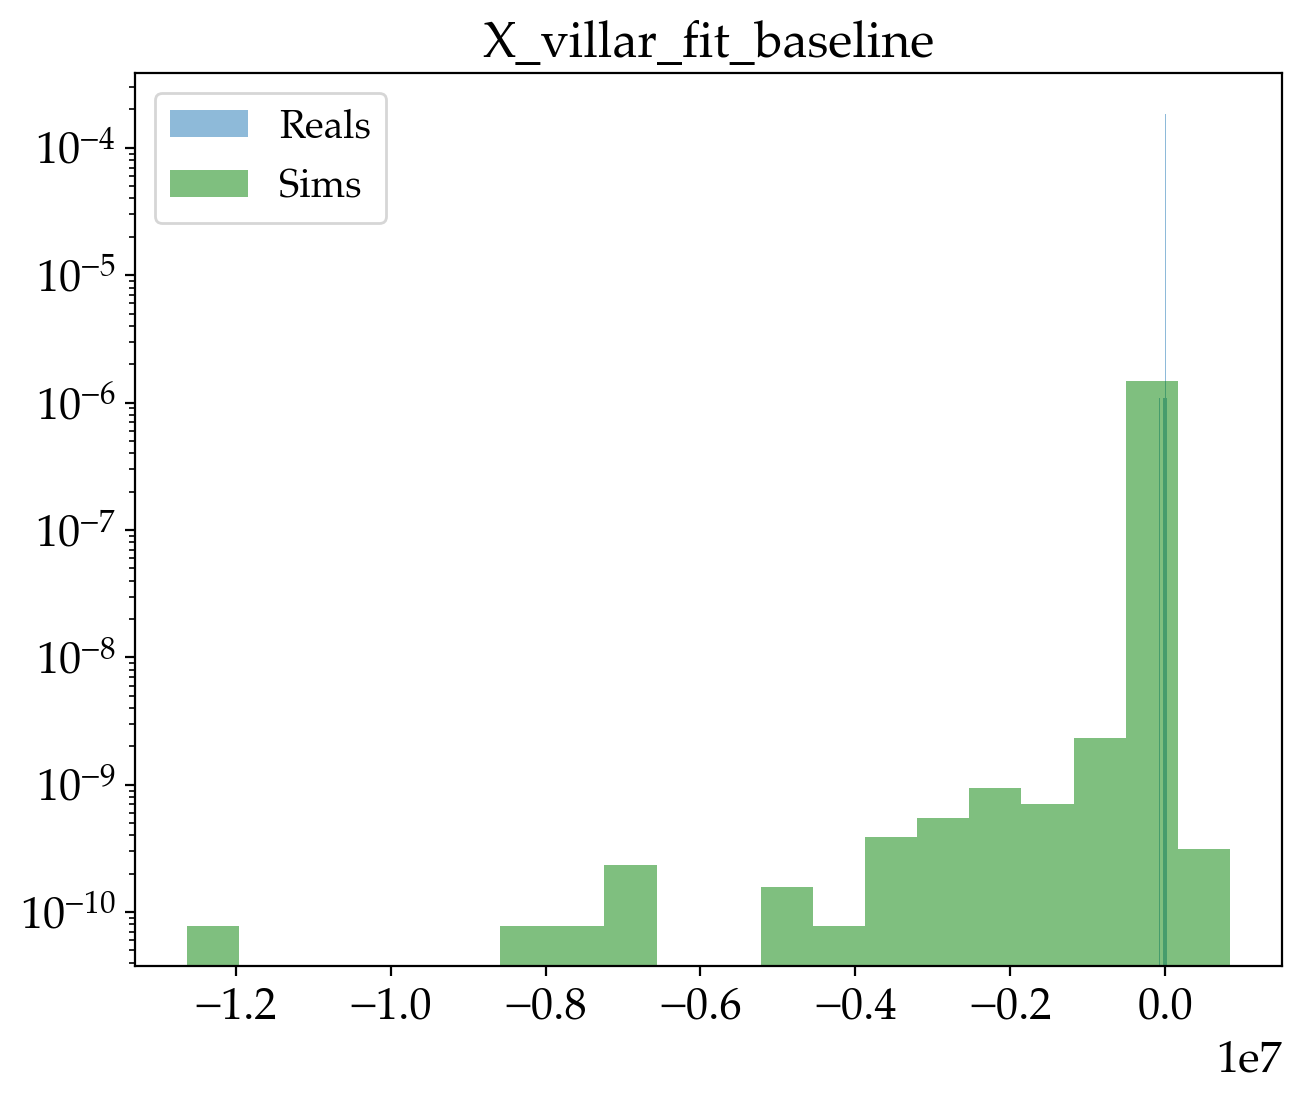

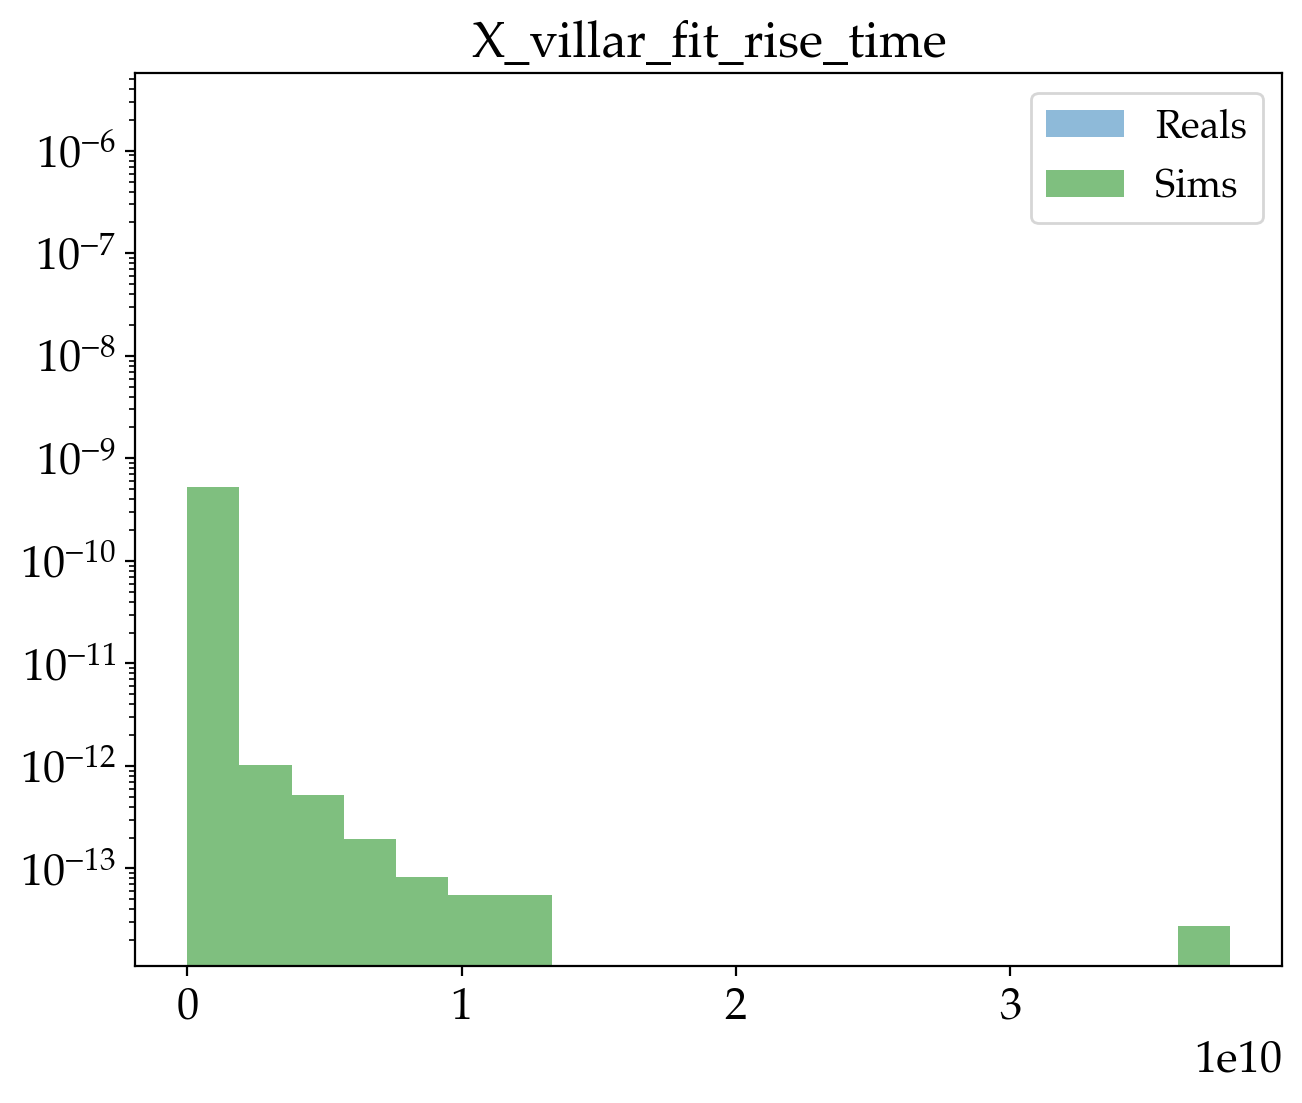

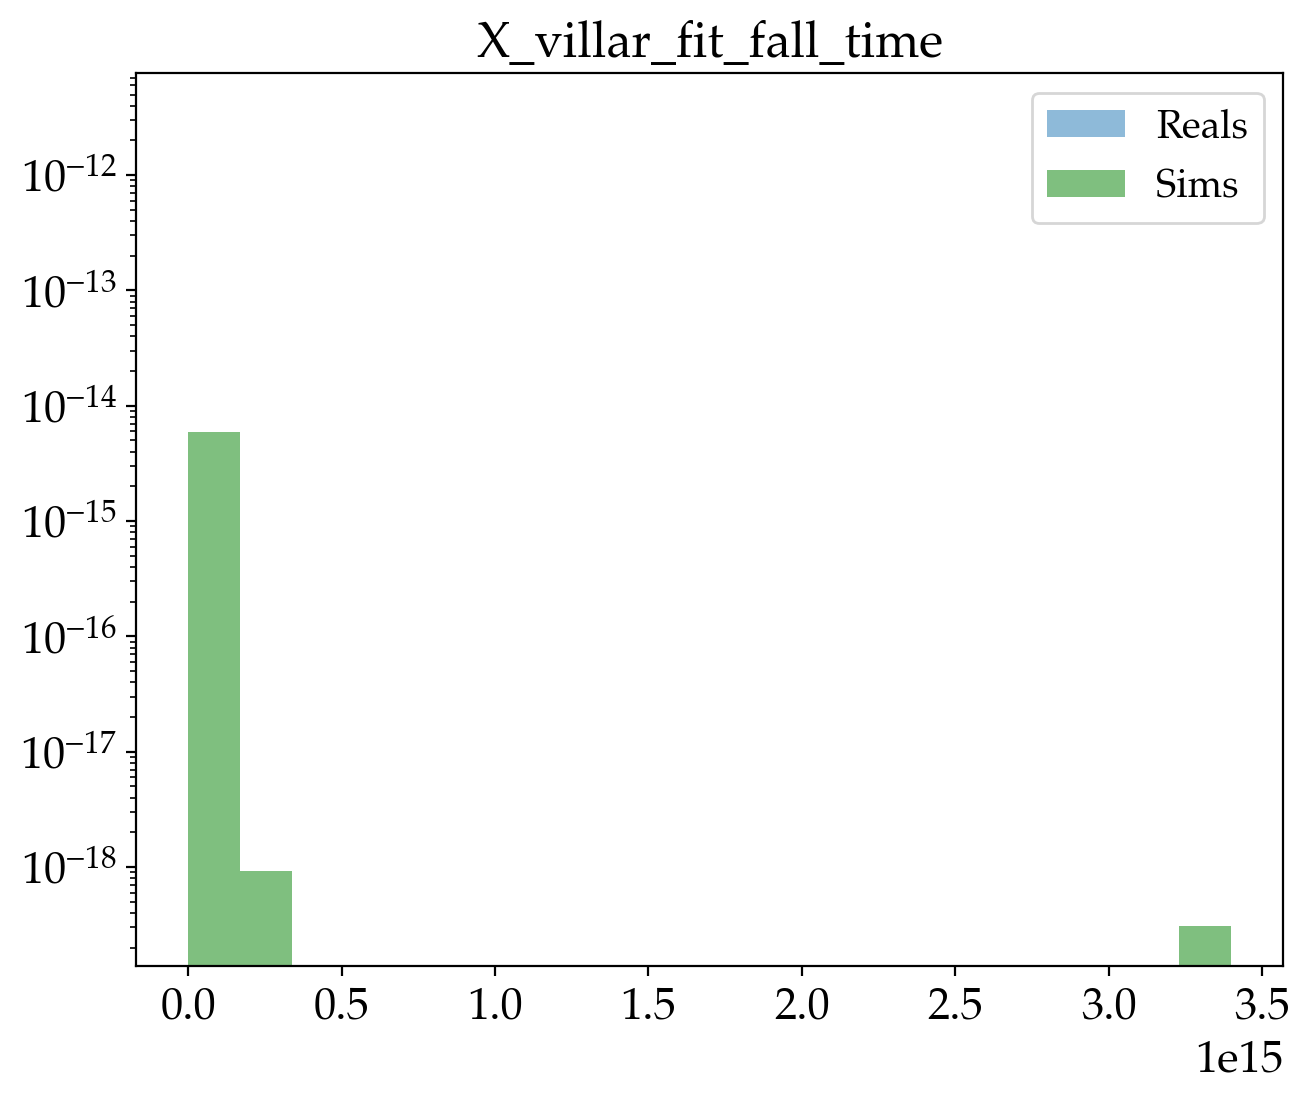

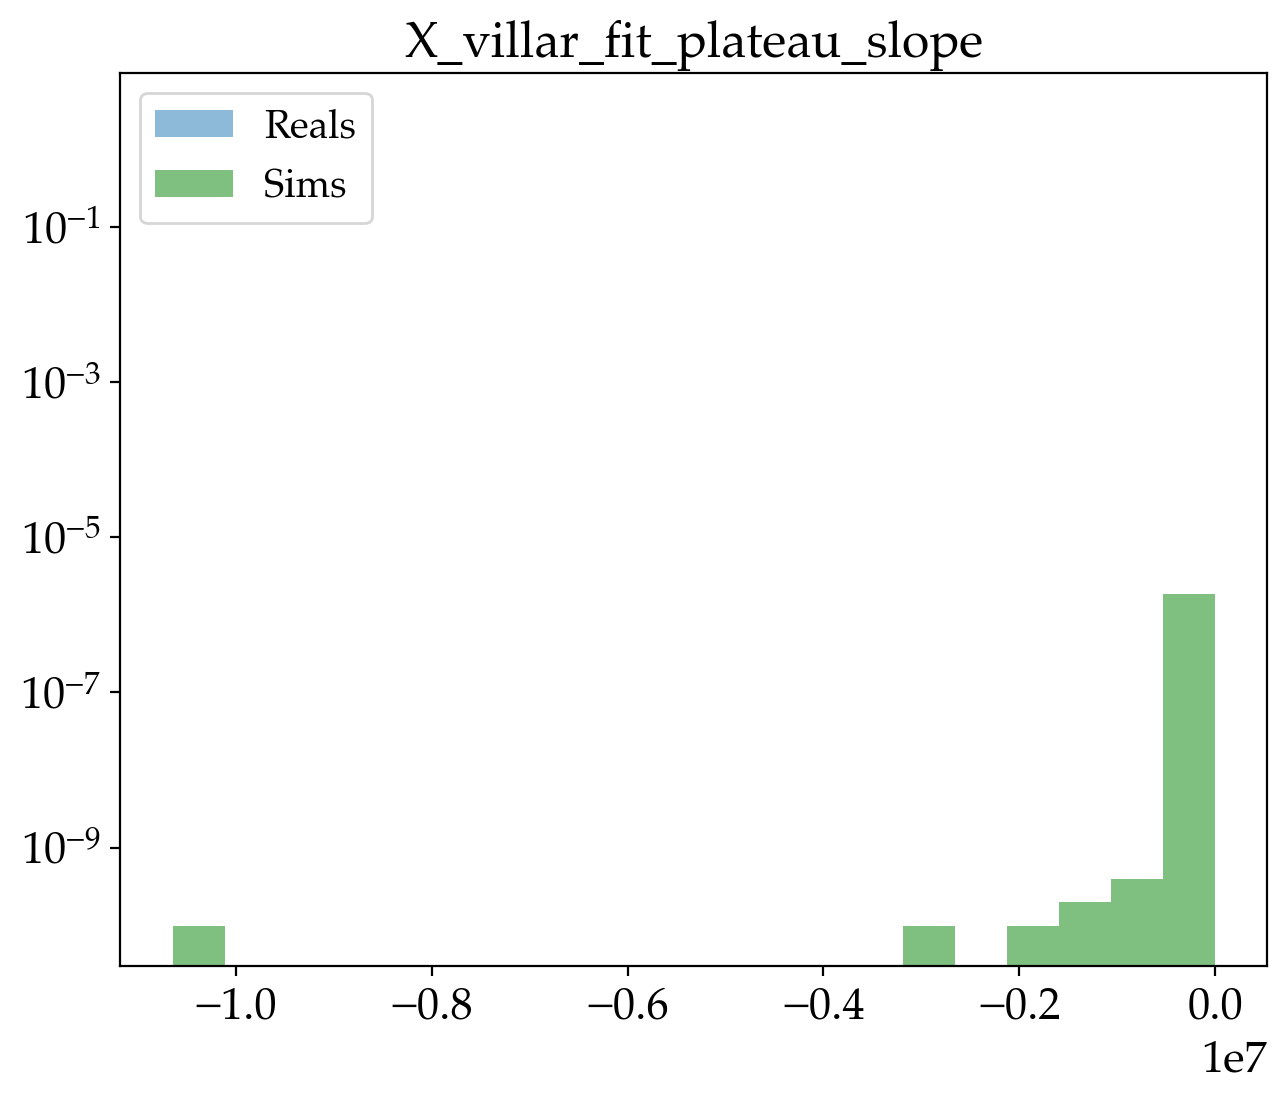

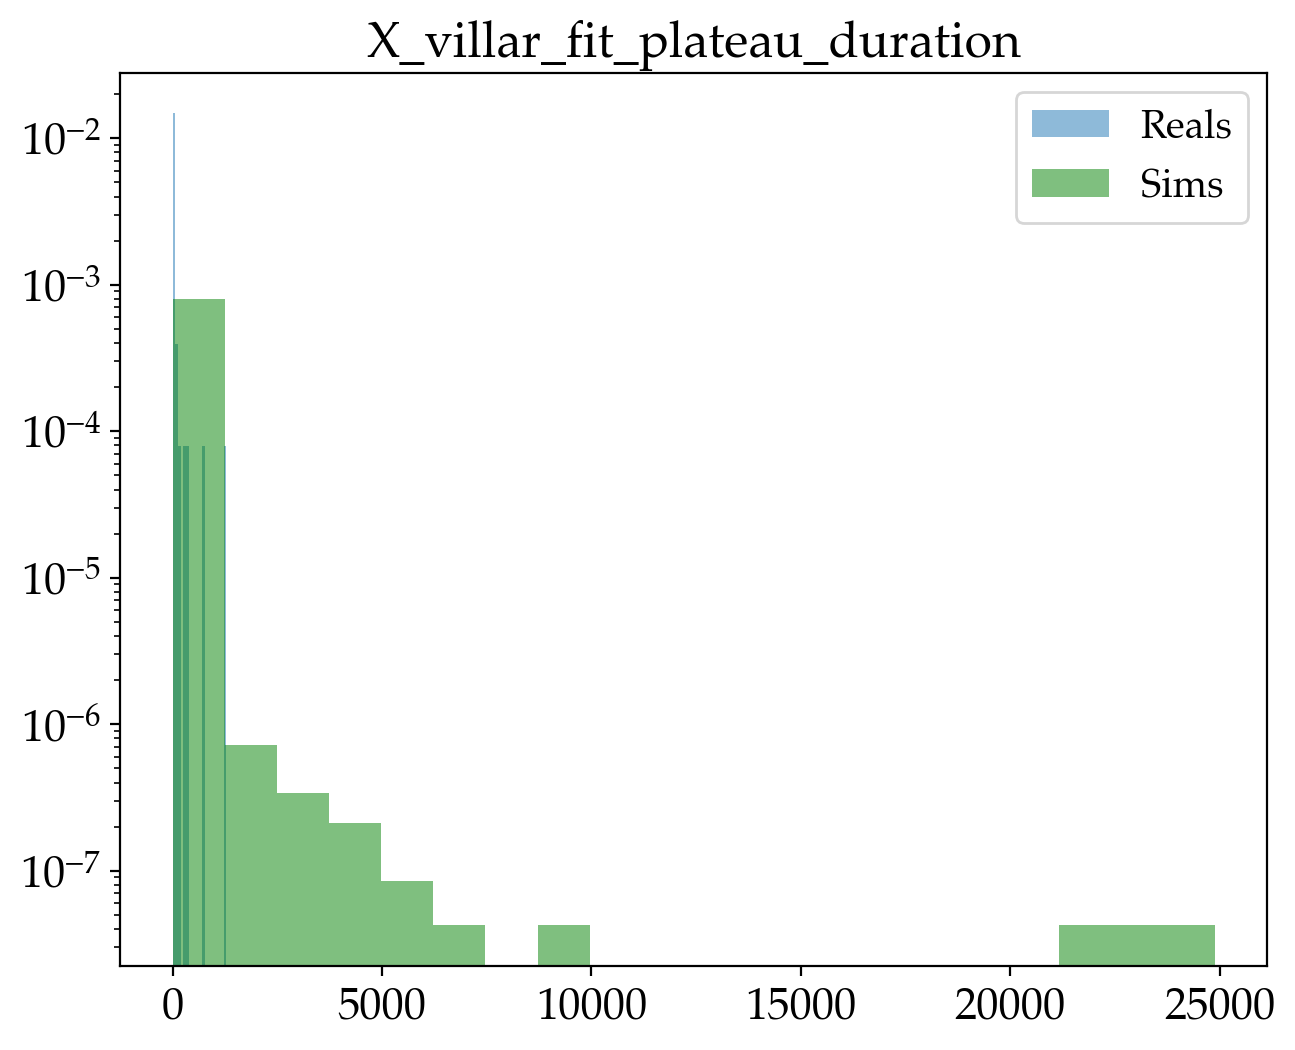

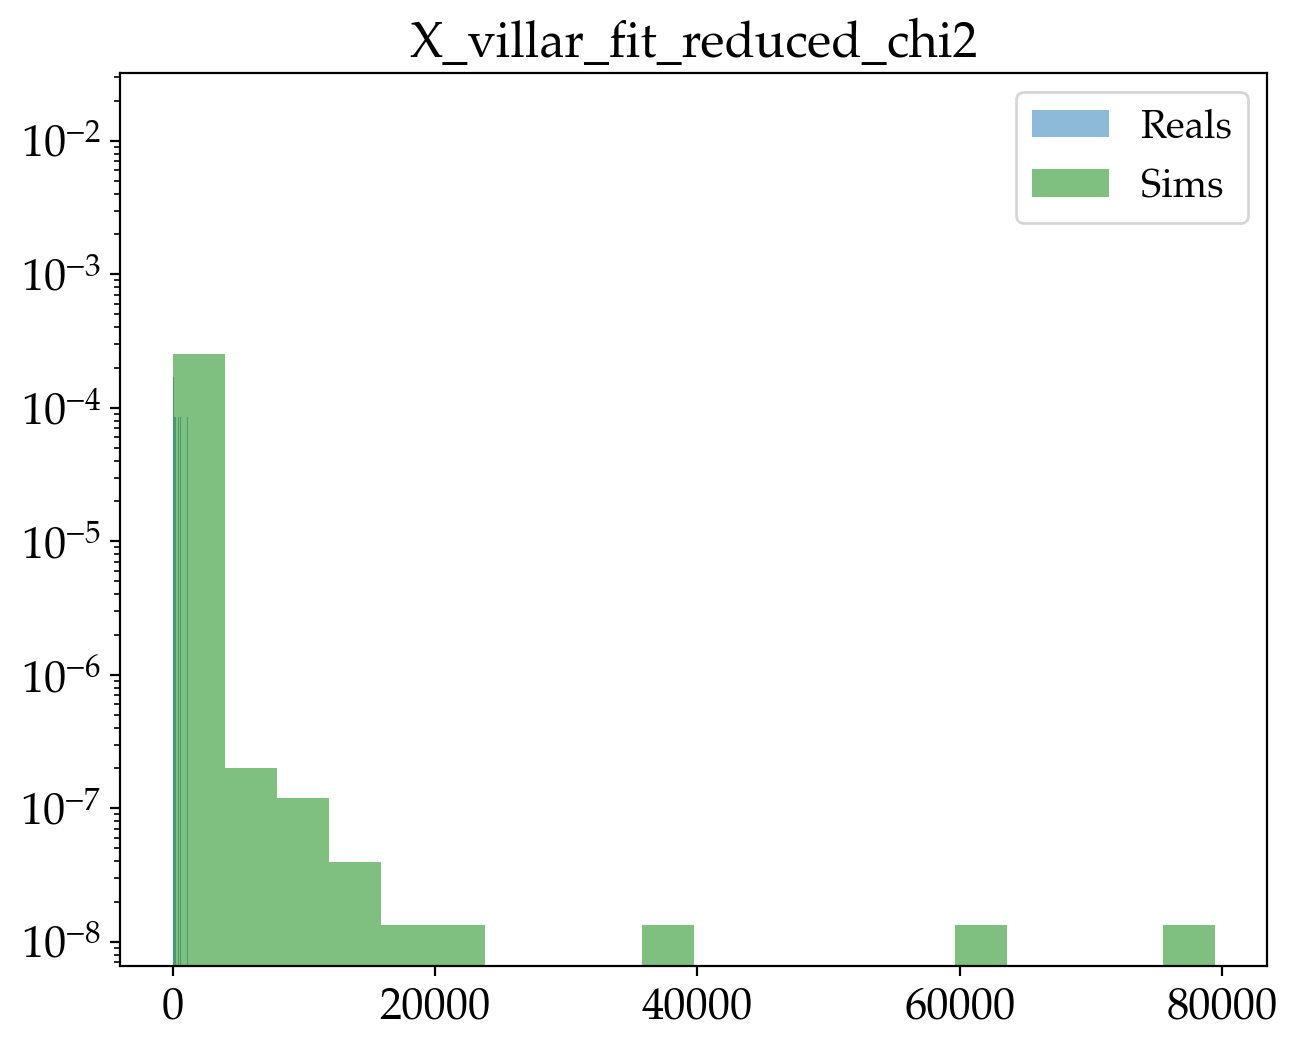

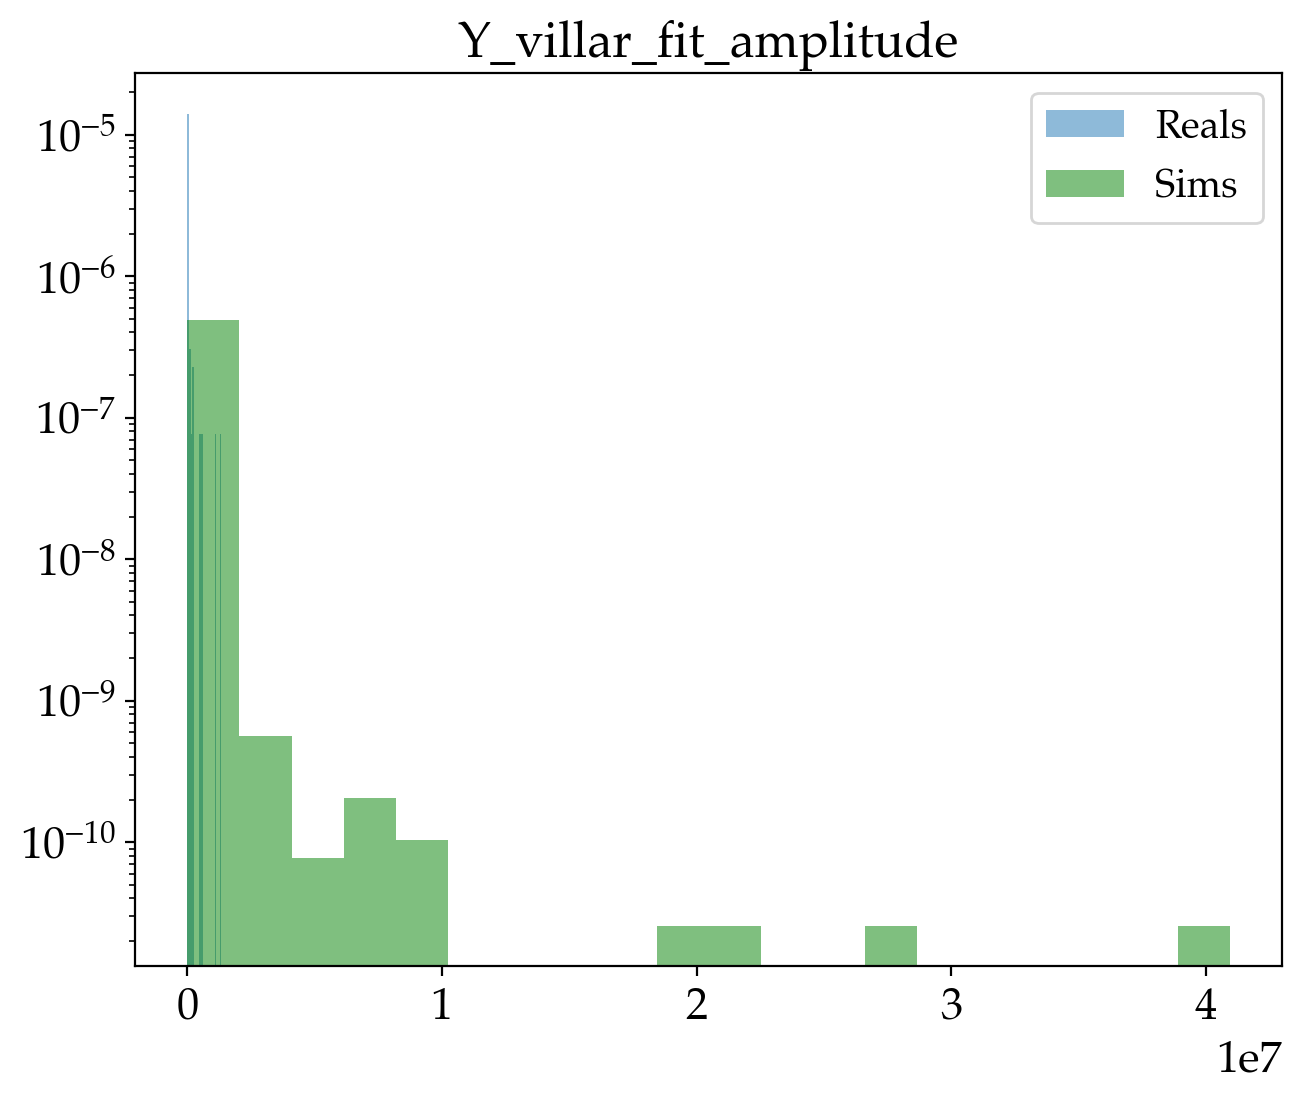

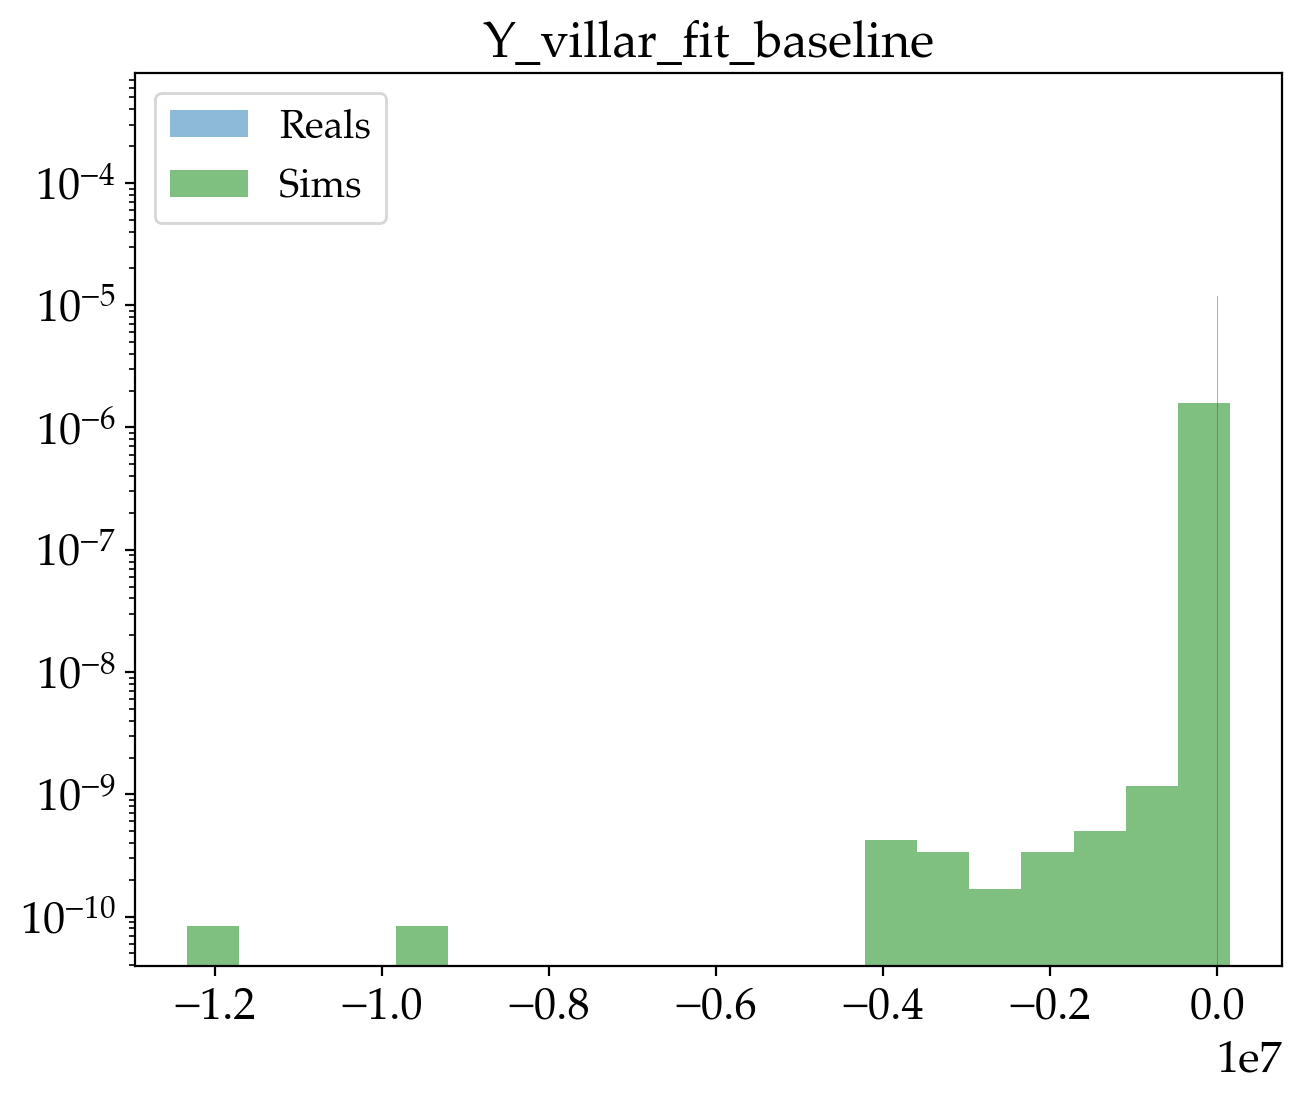

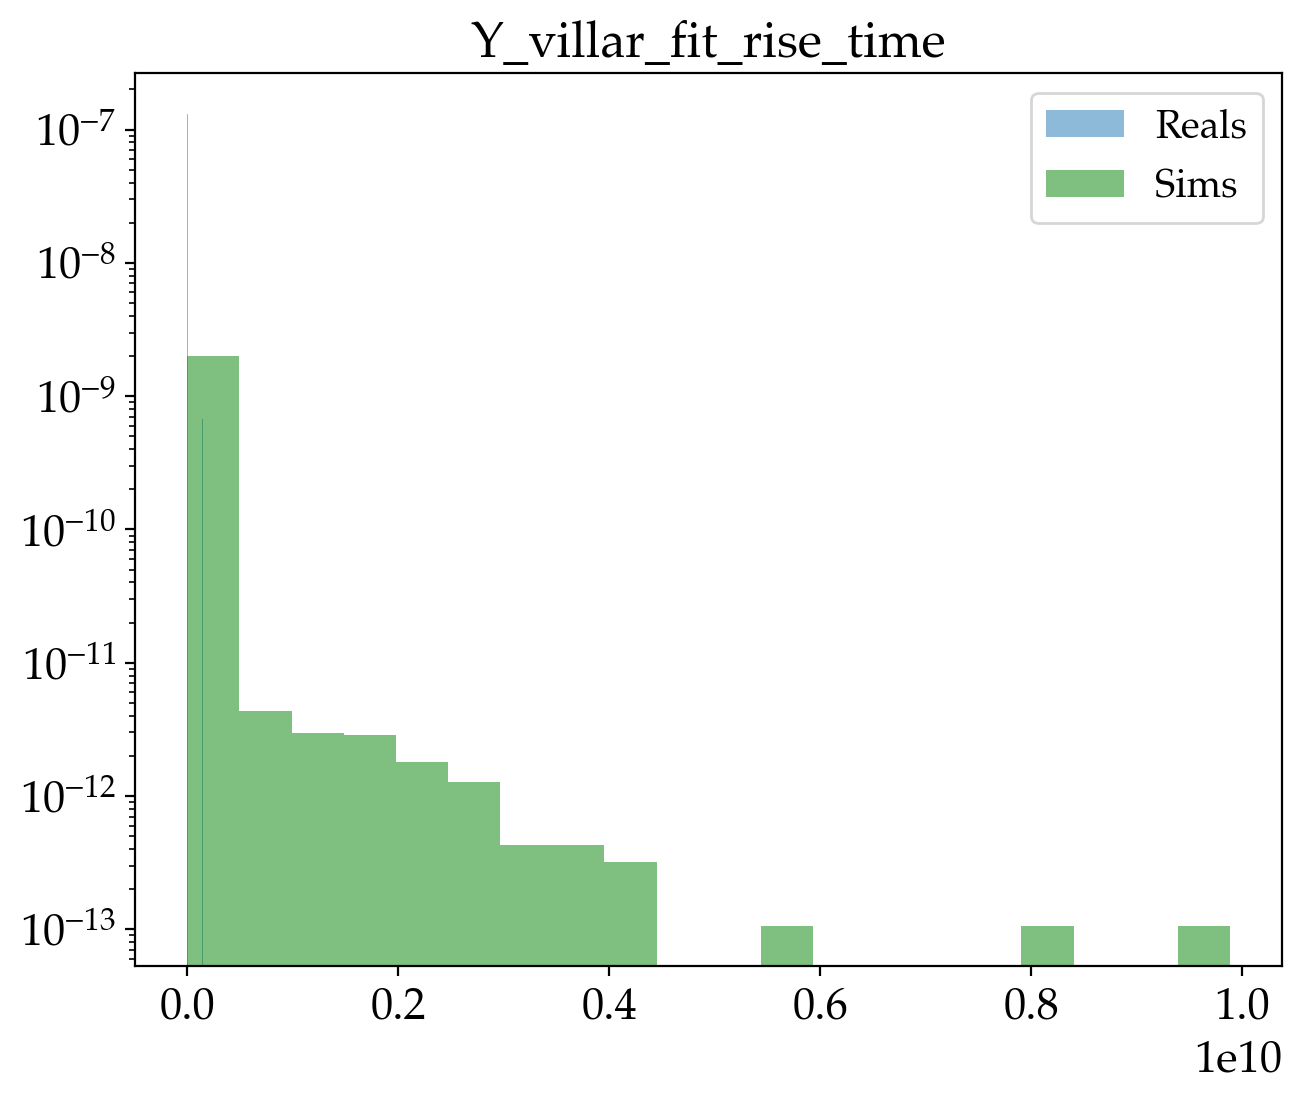

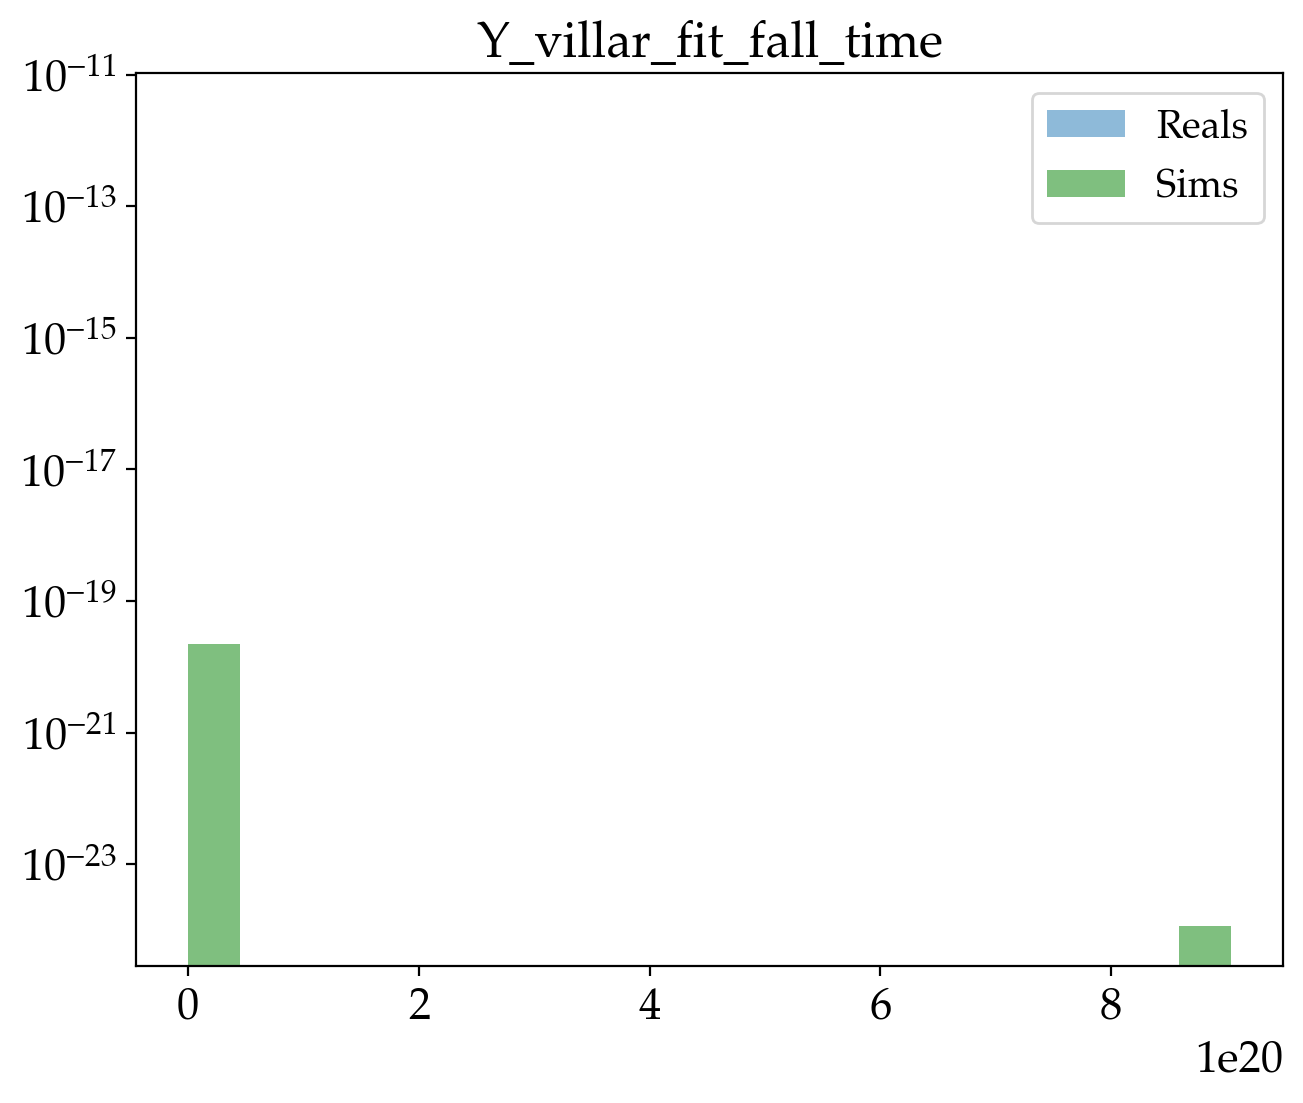

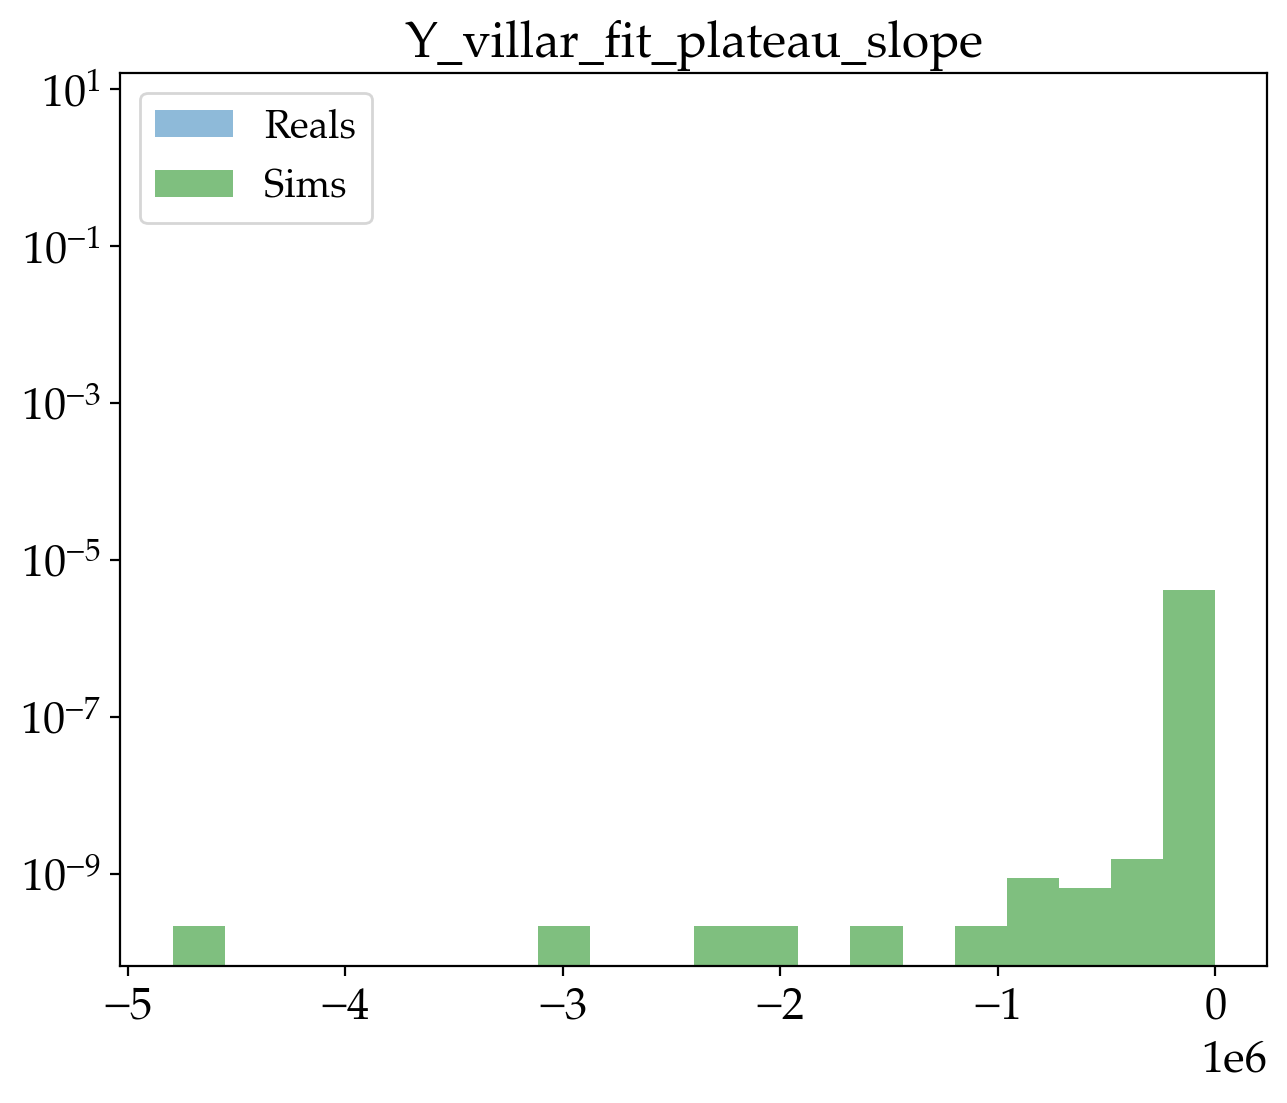

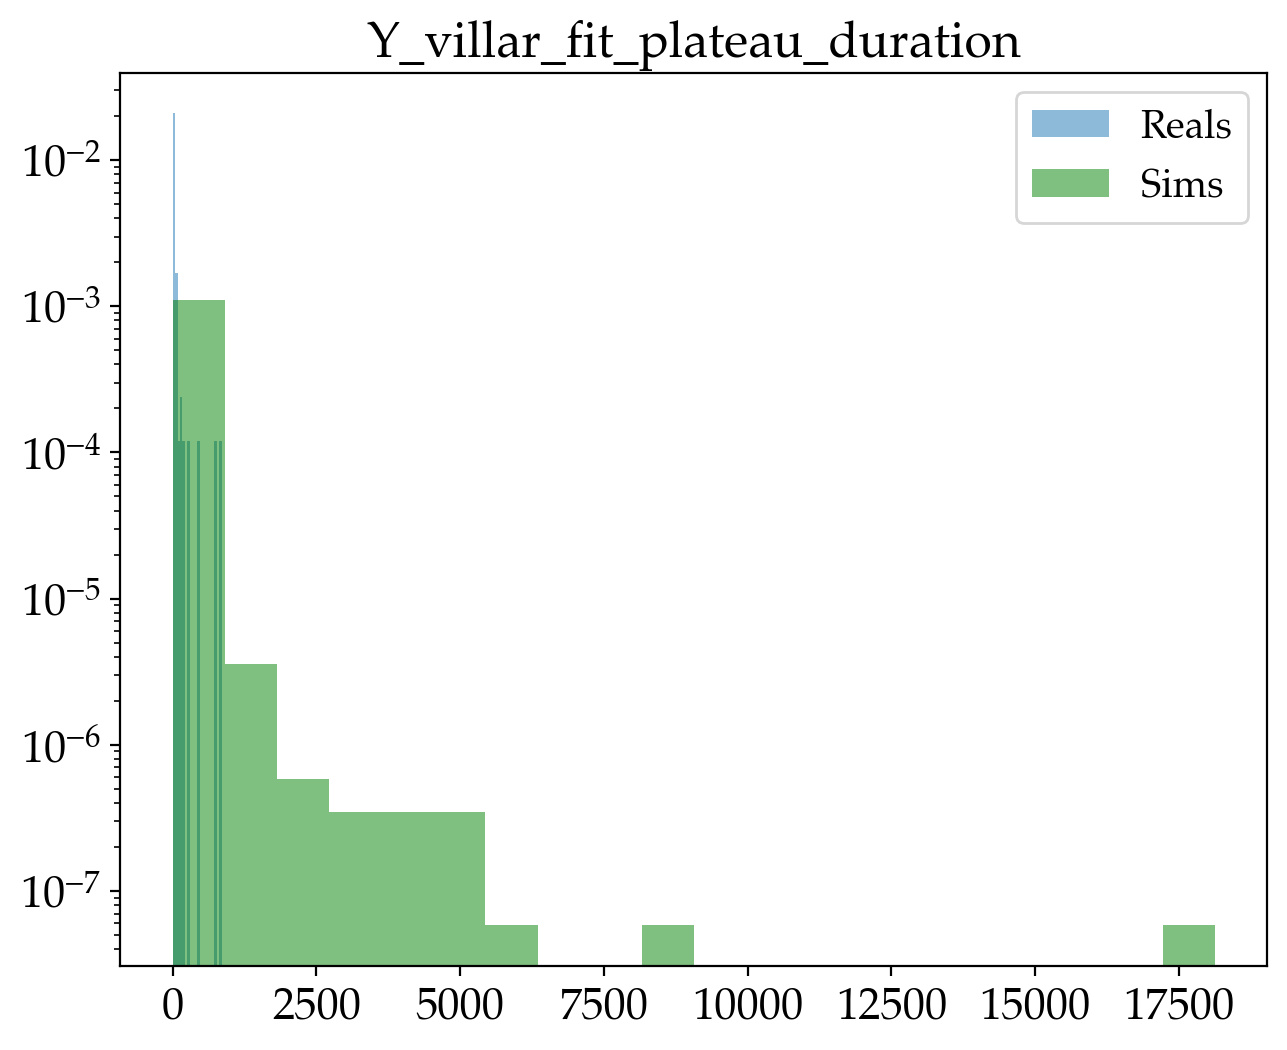

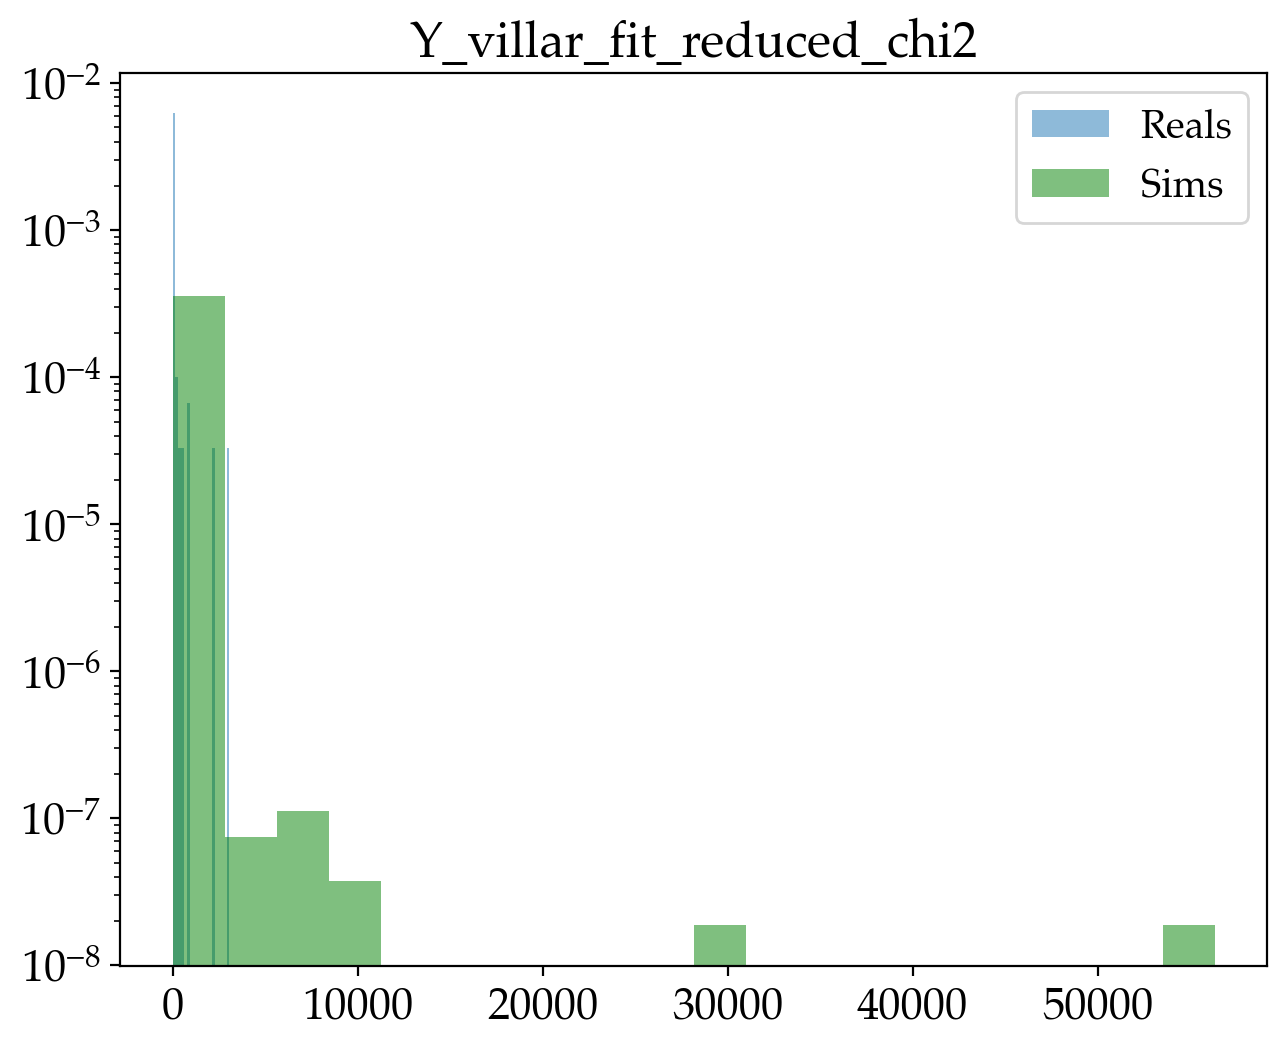

In [83]:
'''
MAX
MIN
MEDIAN
MEAN
Standard Deviation

make an array of the given values for each col for the bins and make a 'loop up table' and get it nice


'''
for col in dr4_df.columns:
    fig = plt.figure()
    plt.hist(dr4_df[col], bins = 20, label = "Reals", density = True, alpha = 0.5)
    plt.hist(fakes_df[col], bins = 20, color = 'g', label = 'Sims', density = True, alpha = 0.5)
    plt.legend()
    plt.yscale('log')
    plt.title(col)
    plt.show()

# PCA 

In [84]:
#Use PCA for real and fake w/ the number of reduced dimension (14 -> 8)
def applypca(dataset_real, dataset_fakes, pca_num):
    X_real = dataset_real
    X_fakes = dataset_fakes
    
    ss = StandardScaler()
    scaled_X_real = ss.fit_transform(X_real)
    pca = PCA(pca_num) # PCA(n_components=8)
    
    # apply same PCA to both real and fakes data
    pcs_X_real = pca.fit_transform(scaled_X_real) #Fit the model with X and apply the dimensionality reduction on X.
    pcs_X_fakes = pca.transform(ss.transform(X_fakes)) #Apply dimensionality reduction to X.
    
    score = pcs_X_real[:,0:2]
    coeff = np.transpose(pca.components_[0:2, :])

    return pca, pcs_X_real, pcs_X_fakes, score, coeff

def applyppca(dataset_real, dataset_fakes, pca_num):
    np.random.seed(42)
    # convert the datasets to numpy arrays (I haven't included the fakes in the EM step yet)
    X_real = dataset_real.to_numpy() 
    X_fakes = dataset_fakes.to_numpy()
    
    t,d = X_real.shape
    
    # initialize W with random numbers, shape (d, pca_num)
    W = np.random.randn(d, pca_num)
    W_hat = np.zeros((d, pca_num))
    
    # calculate the mean across all data points
    mean = np.mean(X_real, axis=0) 
    
    # calculate S
    S = (1/t)*(X_real - mean[np.newaxis,:]).T @ (X_real - mean[np.newaxis,:])
    
    # initialize the variance to 1
    var = 1

    # calculate the norm squared between current and past weight matrix as a convergence metric
    norm = np.linalg.norm(W-W_hat)**2
    
    # EM step
    while norm > 0.0001:
        
        # calculate M and its inverse
        M = W.T @ W + var * np.eye(pca_num)
        M_inv = np.linalg.pinv(M)
        
        # update W
        W_hat = S @ W @ np.linalg.pinv(var * np.eye(pca_num) +(M_inv @ W.T @ S @ W)) 
        
        # update the variance with new W
        var = (1/d)*np.trace(S - S @ W @ M_inv @ W_hat.T)
        
        # update the norm squared
        norm = np.linalg.norm(W-W_hat)**2
        
        # set current W to old W
        W = W_hat

    # apply the derived W to the centred data 
    pca_X_real = W.T @ (X_real - mean[np.newaxis,:]).T 
    mean_fake = np.mean(X_fakes, axis=0)
    pca_X_fake = W.T @ (X_fakes - mean[np.newaxis,:]).T
    # calculate the score and coeffs from the pca application and W
    score = pca_X_real.T[:,0:2]
    coeff = np.transpose(W.T[0:2, :])

    return W, var, pca_X_real, pca_X_fake, score, coeff

ss = StandardScaler()
smaller = ss.fit_transform(dr4_df)
test = pd.DataFrame(smaller)

ss = StandardScaler()
smaller = ss.fit_transform(fakes_df)
fake_small = pd.DataFrame(smaller)

pca, pcs_X_real, pcs_X_fakes, score, coeff = applypca(dataset_real=dr4_df, dataset_fakes=fakes_df, pca_num=8)

W, var, pcs2_X_real, pcs2_X_fake, score2, coeff2 = applyppca(dataset_real=test, dataset_fakes=fake_small, pca_num=8)

# comparison between original PCA and new PPCA
print('original', pcs_X_real[0])
print('new', pcs2_X_real.T[0])


original [-0.23040313 -0.76740055  0.19073456  0.8104439   0.17222564 -0.03467763
  0.36435369  0.73842621]
new [-0.66135533  0.68299885 -0.03857264  0.03631116  0.08385021  0.53760949
 -0.061232   -0.74992208]


In [85]:
# Comparison between original PCA and new PPCA
# print('Original PCA components:')
# for i in range(3):  # Print the first three components
#     print(f'Component {i+1}: {pcs_X_real[:, i]}')

# print('\nNew PPCA components:')
# for i in range(3):  # Print the first three components
#     print(f'Component {i+1}: {pcs2_X_real[i]}')

#Subtract the 3rd componet from pca to ppca 
print(pcs2_X_real[2].shape, pcs_X_real[:, 2].shape)
pcs2_X_real[2] - pcs_X_real[:, 2]

(196,) (196,)


array([-2.29307202e-01, -1.01895307e+00,  1.03038258e+00,  1.27504789e+00,
       -1.42804097e+00, -1.14570867e+01,  1.22504459e+00, -6.51407638e-01,
       -1.31536171e+00,  4.30747820e-01,  4.26202433e-01,  3.47926251e-01,
       -1.05094899e+00, -1.92853113e-01,  3.28860489e-01,  1.06121691e+00,
       -5.64387367e-01,  7.19802966e-01, -3.88408294e-01,  1.55801618e+00,
       -6.90880514e-01,  7.54705794e-01, -1.31135266e+00,  3.84177229e-01,
       -1.37494855e+00, -1.37132723e+00, -2.27051020e+00,  4.52666967e-01,
        1.40281501e-01,  7.10504120e-01,  4.64015946e+00,  3.46729682e-01,
       -4.12886529e-01,  9.66949200e-01,  4.65094273e-01,  1.63243443e+00,
       -1.00419912e+00, -5.69809283e-02,  1.52956168e-01, -6.44125091e-01,
       -1.46334642e+00, -4.50907420e-01, -3.20236895e-01, -1.41430014e-01,
       -6.93152955e-01,  4.18626292e+00,  2.10542088e+00, -1.70113256e+00,
       -1.35545025e+00,  1.23793095e+00, -1.38783328e+00,  1.18626915e-01,
       -7.86406635e-01,  

In [86]:
#Function to plot the result of the PCA 3 cells down
def pcaplot(score, coeff, datacolor, dataframe):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs*scalex,ys*scaley, c=datacolor, s=6, alpha=0.6) 
    plt.xlim(-1,1)
    plt.ylim(-1,1) 
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], head_width= .003, color = 'r',alpha = 0.5)
        #dataframe_latex_read = [r.replace('_', '\_') for r in dataframe.columns.values]
        plt.text(coeff[i,0]* 1.12, coeff[i,1] * 1.12, list(dataframe.columns.values)[i], 
                    color = 'darkblue', ha = 'center', va = 'center', fontsize = 10)

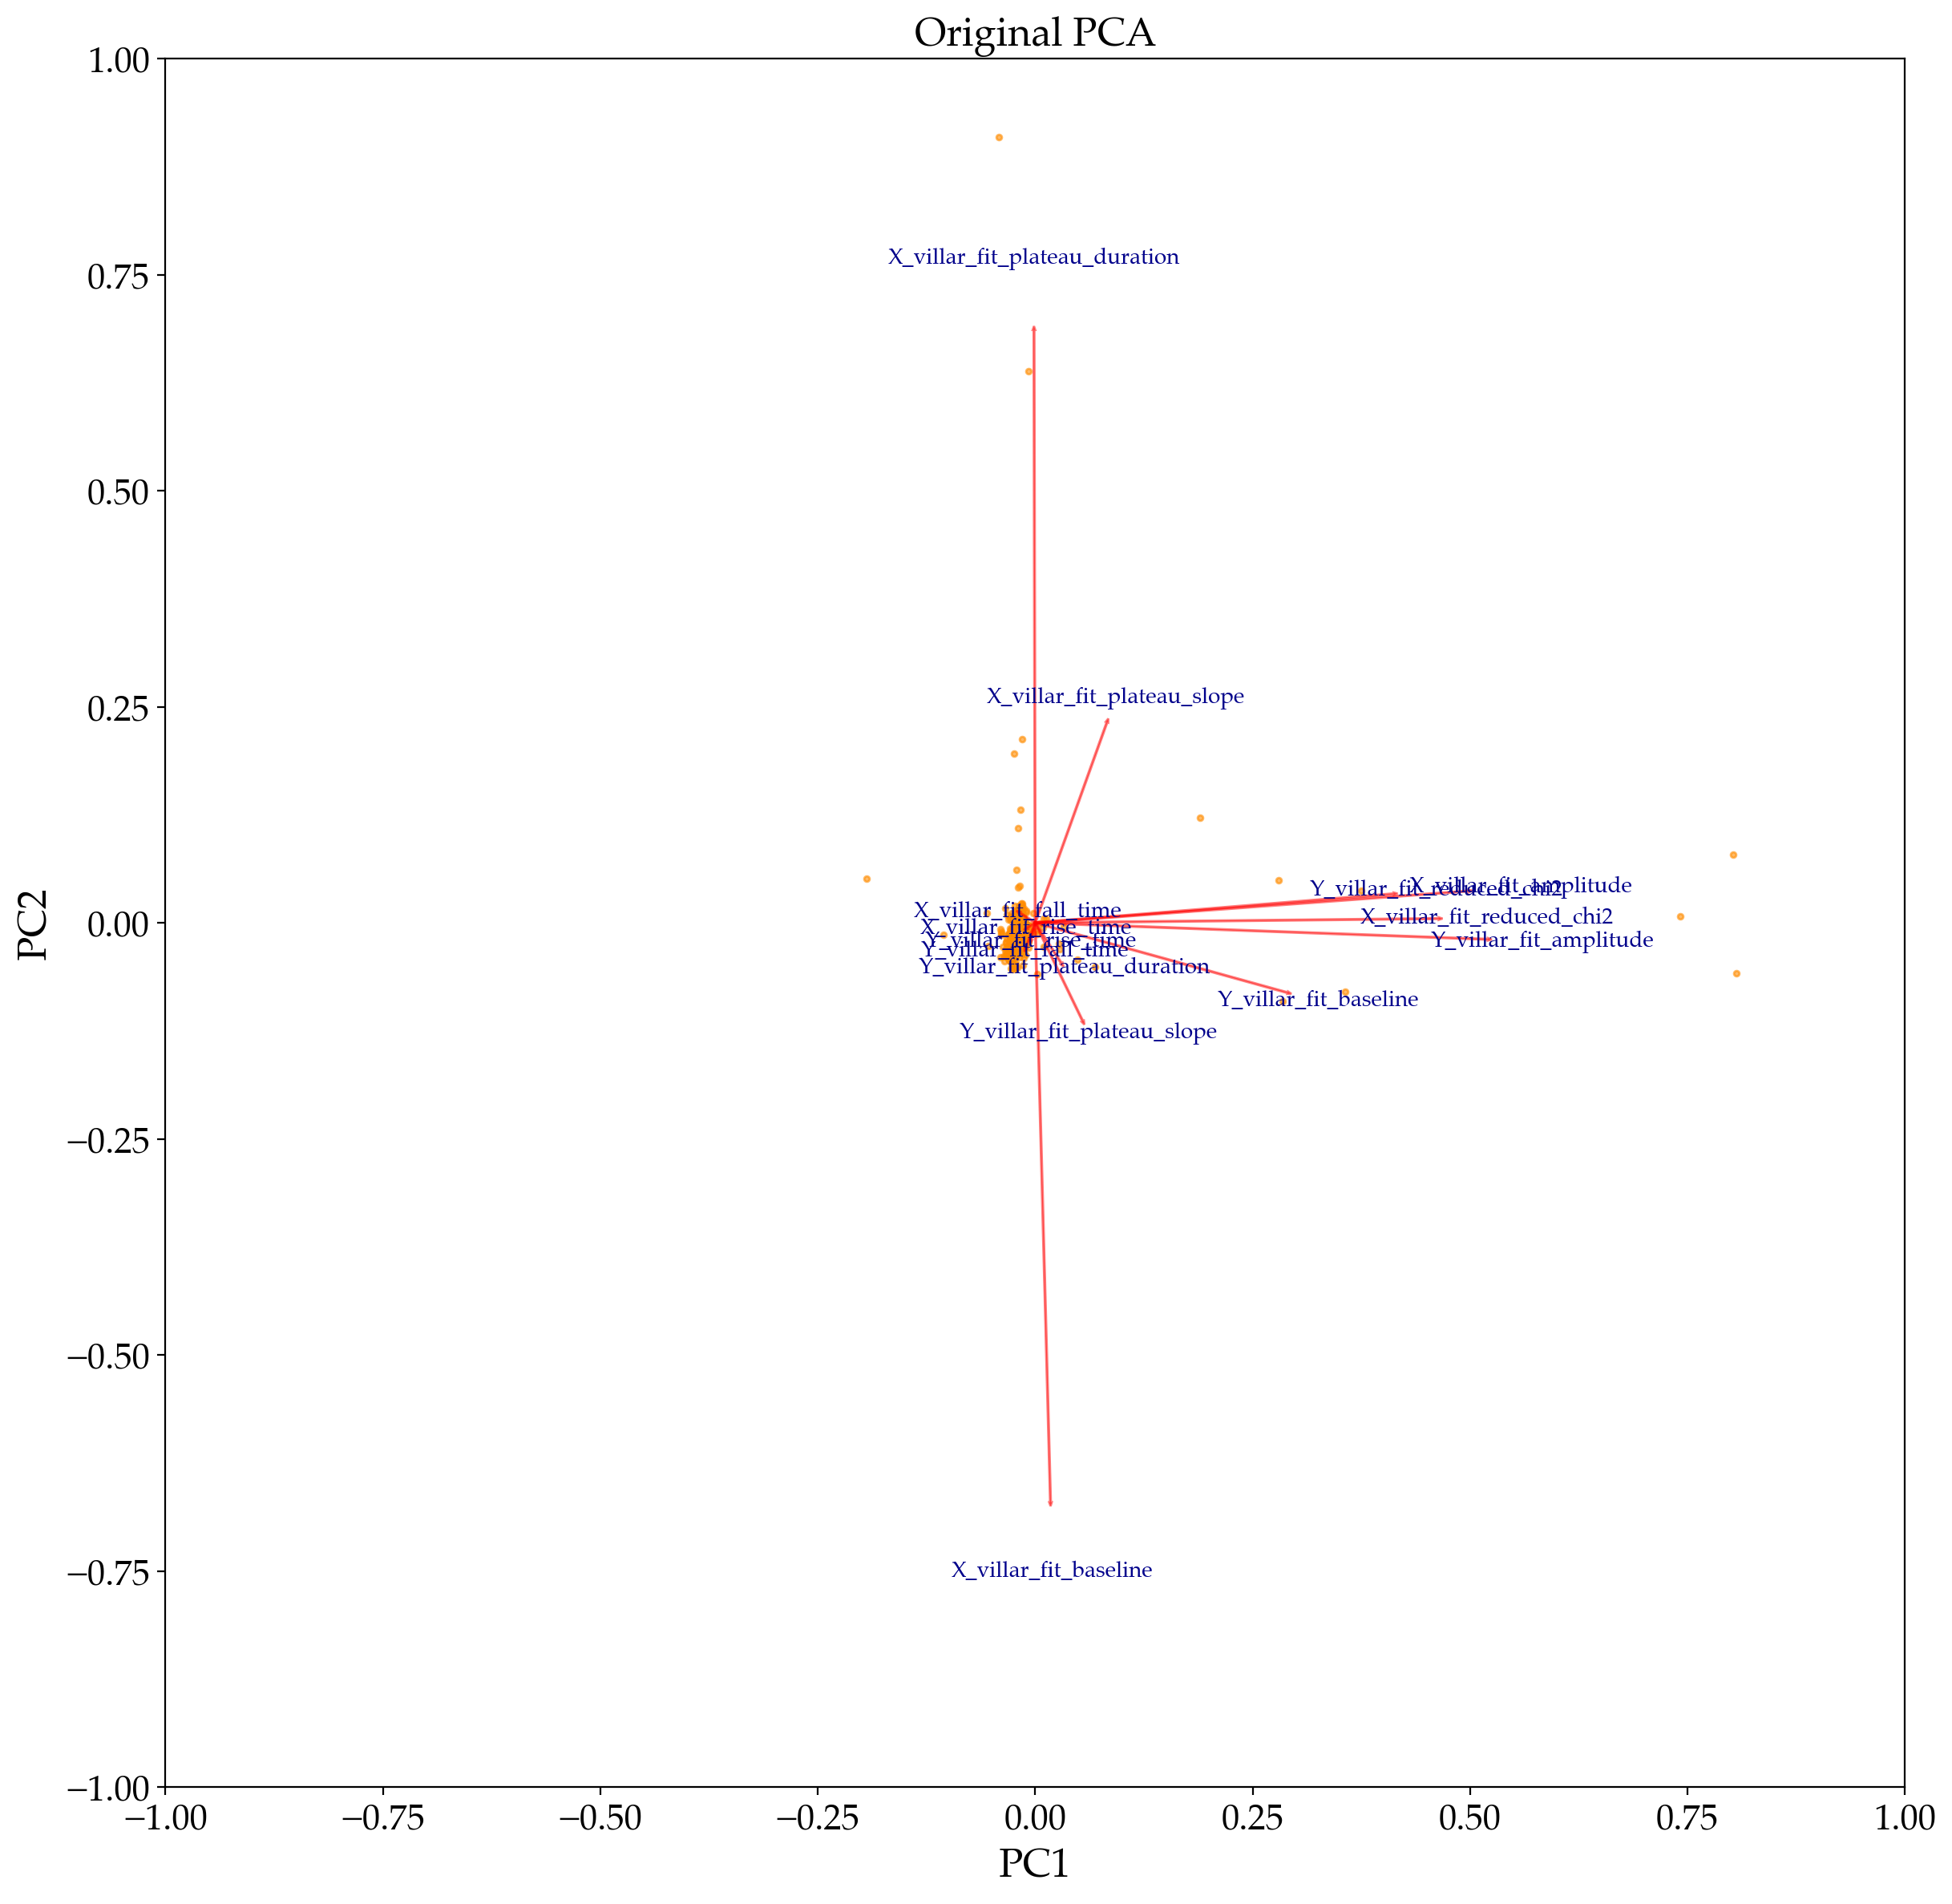

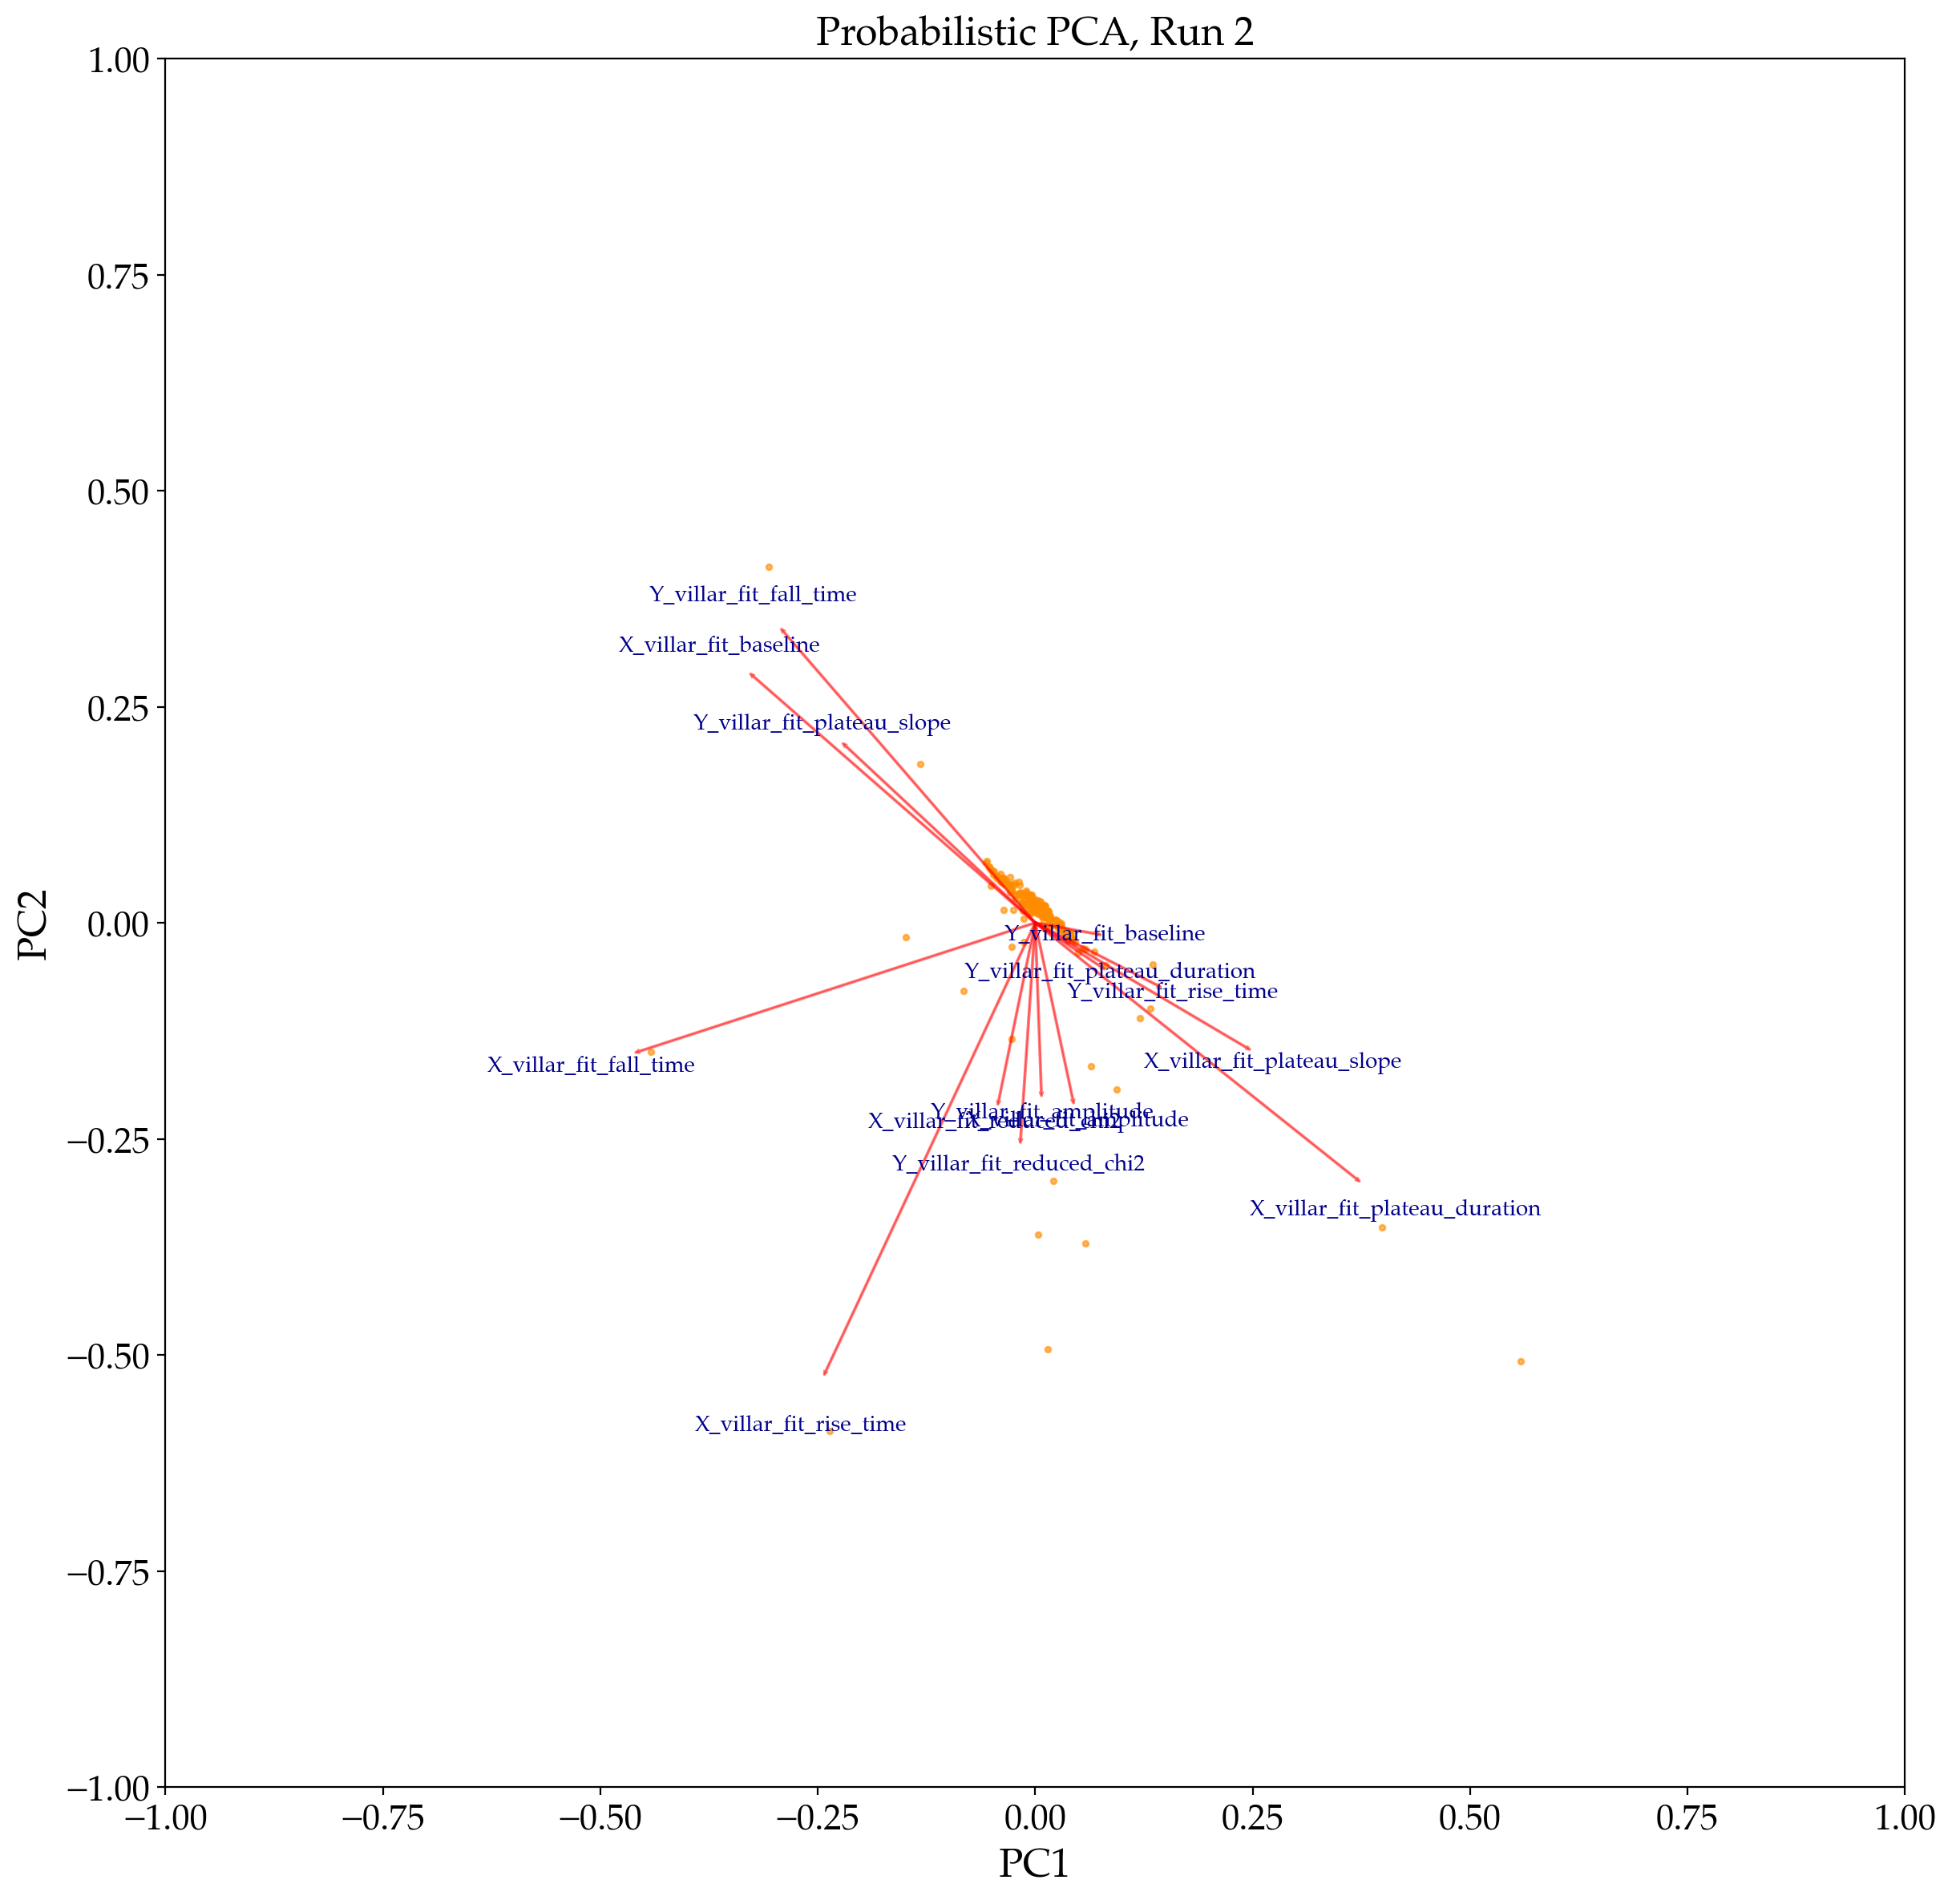

In [87]:
fig, ax = plt.subplots(figsize=(14, 14))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Original PCA")
pcaplot(score, coeff, 'darkorange', dataframe = fakes_df) 
#plt.savefig('./figures/pca_overlay_data.png', dpi=300, bbox_inches='tight')
#Grouping means correleated. Further out means less coreleated

fig, ax = plt.subplots(figsize=(14, 14))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Probabilistic PCA, Run 2")
pcaplot(score2, coeff2, 'darkorange', dataframe = fakes_df) 

# Build DFs from first (8) PCs

In [88]:
pcs2_X_fake_df = pd.DataFrame(data=pcs2_X_fake.T, index=fakes_df.index)
pcs2_X_fake_df

,0,1,2,3,4,5,6,7
ObjectID,,,,,,,,
_4877922_SNIa,-0.020762,0.125595,-0.134331,-0.117749,0.113793,0.013379,0.056420,0.059006
_1309355_SNIa,-1.454188,-4.027442,0.760112,-1.633171,1.043100,-1.261553,1.791835,-1.334184
_3053534_SNIa,-0.017218,0.139978,-0.162730,-0.178060,0.084777,0.009440,0.026037,0.017697
_3315509_SNIa,0.081404,0.078520,0.168921,-0.430607,-0.461843,-0.086817,-0.716069,-0.655310
_4109434_SNIa,-0.079164,0.168244,-0.120798,-0.087947,0.154979,0.012695,-0.000519,-0.012081
...,...,...,...,...,...,...,...,...
_2303364_SNIa,-0.050713,0.064804,0.061714,0.111999,0.086493,-0.037553,-0.015131,0.051276
_4431841_SNIa,-0.040773,0.151373,-0.122444,-0.151517,0.084780,-0.007288,-0.041234,-0.042559
_3414162_SNIa,-0.019558,0.130759,-0.153990,-0.141289,0.105047,0.017495,0.061591,0.056473


In [89]:
# pcs_X_real_df = pd.DataFrame(data=pcs_X_real, index=dr4_df.index)
# pcs_X_real_df
# print(pcs_X_real.shape)
# print(pcs2_X_real.shape)
pcs2_X_real_df = pd.DataFrame(data=pcs2_X_real.T, index=dr4_df.index)
pcs2_X_real_df

,0,1,2,3,4,5,6,7
ObjectID,,,,,,,,
2019pmd,-0.661355,0.682999,-0.038573,0.036311,0.083850,0.537609,-0.061232,-0.749922
2019tvv,-0.028643,0.235158,-0.039247,0.112811,-0.409341,-1.013545,-0.124211,-0.042103
2019wka,-0.060315,0.135189,-0.306615,-0.234033,1.097689,0.912074,-0.022112,0.033813
2019wqf,-0.208945,0.274469,-0.234394,-0.209132,1.216633,1.263971,0.036298,-0.171352
2019wyp,1.107092,-0.597354,-0.267911,-1.066945,-1.929740,-0.251748,0.655303,0.687960
...,...,...,...,...,...,...,...,...
2021xjh,0.244416,0.043973,-0.440969,-0.432429,0.966170,0.299182,-0.014739,0.244978
2021xkm,0.042274,0.254152,-0.340093,-0.330797,-0.386241,-0.695259,-0.094817,-0.084031
2021yab,-0.756672,0.872959,-0.210862,-0.105212,-0.223397,0.127915,-0.099904,-0.907692


# Find variance of 8 PCs...

In [90]:
#Percentage of variance explained by each of the selected components.
pca_var_ratio = pca.explained_variance_ratio_
pca_var_ratio

# calculate the variance at each dimension 
pca2_var = np.var(W, axis=0)

print(pca2_var.shape, pca_var_ratio.shape)

(8,) (8,)


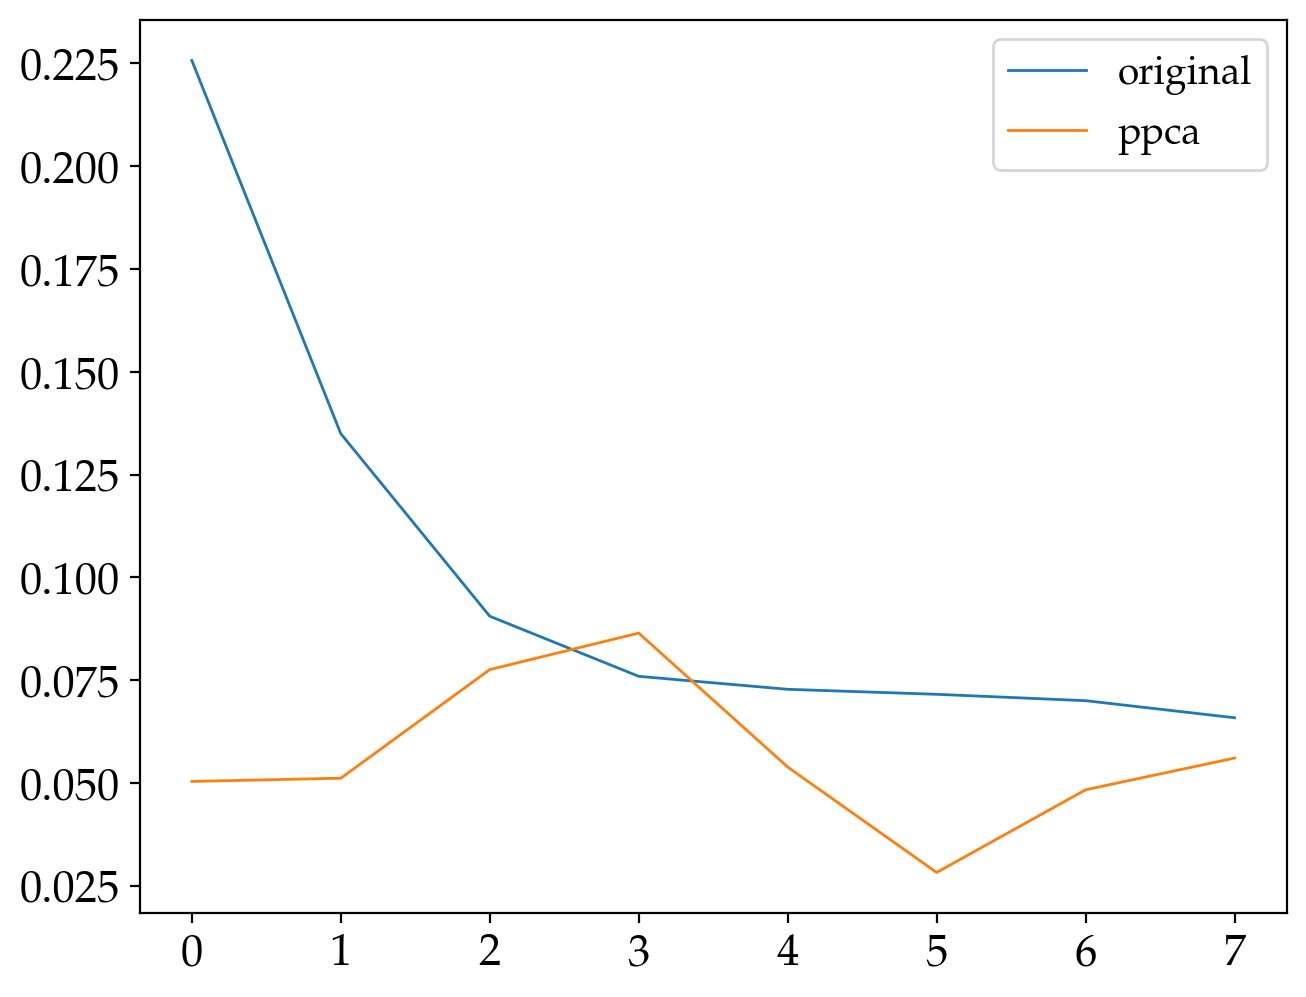

normal pca [0.22572361 0.36066814 0.45120553 0.52712349 0.59988366 0.67142643
 0.74141972 0.8072546 ]
new ppca [0.05034981 0.10147754 0.17903233 0.26546807 0.31931988 0.34751843
 0.39583106 0.45186431]


In [91]:
plt.plot(pca_var_ratio, label='original')
plt.plot(pca2_var, label='ppca')
plt.legend()
plt.show()

print('normal pca', np.cumsum(pca_var_ratio))
print('new ppca', np.cumsum(pca2_var))

In [92]:
print("summed variance First 14 PCs:", np.cumsum(pca_var_ratio)[-1])

print("summed variance First 14 PCs PPCA:", np.cumsum(pca2_var)[-1])

summed variance First 14 PCs: 0.8072546034615871
summed variance First 14 PCs PPCA: 0.4518643065051263


# Most important features mathematically

In [93]:
print(abs( W)) #has shape (8, 14) [n_components, n_features].

[[0.04339402 0.2051039  0.48416694 0.56846032 0.07699045 0.20872795
  0.03341699 0.17957802]
 [0.32456344 0.2855985  0.01100484 0.19605544 0.44634892 0.22129059
  0.32778691 0.30749951]
 [0.24097637 0.51941327 0.08935608 0.22136395 0.18374307 0.16884307
  0.2056422  0.24139718]
 [0.45590236 0.14894998 0.28312993 0.04255445 0.23013102 0.04532359
  0.22992786 0.30099897]
 [0.24354396 0.1447675  0.04048355 0.05022609 0.17223475 0.57134502
  0.06138199 0.21568124]
 [0.36992486 0.29679147 0.00679871 0.2044262  0.45129386 0.088499
  0.29493536 0.34052726]
 [0.04214754 0.2066     0.46330338 0.56625157 0.12304817 0.02131865
  0.04070135 0.08652911]
 [0.00708192 0.19654995 0.51482456 0.60623839 0.07041789 0.20174011
  0.06959814 0.12896808]
 [0.07154306 0.01314015 0.33680059 0.33229243 0.13100443 0.24498702
  0.05932444 0.04766276]
 [0.14100504 0.07261009 0.42123921 0.3609761  0.15310418 0.10413396
  0.18967353 0.35377432]
 [0.28944597 0.33703575 0.20833923 0.0923525  0.23519064 0.09739291
  0.

In [94]:
#df to show for each of the dimension, the pca.components_ --> notice it is the same but above we did abs value 
pca_num = []
for i in range(0, 8):
    pca_num.append('PCA{}'.format(i + 1))

pca_comp = pd.DataFrame(W.T, index=pca_num, columns=dr4_df.columns)
#pca_comp.to_csv('./dataframes/pca_feature_importance.csv')
pca_comp

,X_villar_fit_amplitude,X_villar_fit_baseline,X_villar_fit_rise_time,X_villar_fit_fall_time,X_villar_fit_plateau_slope,X_villar_fit_plateau_duration,X_villar_fit_reduced_chi2,Y_villar_fit_amplitude,Y_villar_fit_baseline,Y_villar_fit_rise_time,Y_villar_fit_fall_time,Y_villar_fit_plateau_slope,Y_villar_fit_plateau_duration,Y_villar_fit_reduced_chi2
PCA1,0.043394,-0.324563,-0.240976,-0.455902,0.243544,0.369925,-0.042148,0.007082,0.071543,0.141005,-0.289446,-0.218339,0.076517,-0.016804
PCA2,-0.205104,0.285599,-0.519413,-0.148950,-0.144768,-0.296791,-0.206600,-0.196550,-0.013140,-0.072610,0.337036,0.205005,-0.051505,-0.250714
PCA3,0.484167,-0.011005,0.089356,-0.283130,-0.040484,0.006799,0.463303,0.514825,0.336801,-0.421239,0.208339,0.023775,0.193472,0.444951
PCA4,0.568460,0.196055,-0.221364,0.042554,-0.050226,-0.204426,0.566252,0.606238,0.332292,0.360976,-0.092352,0.087166,-0.157519,0.487639
PCA5,-0.076990,0.446349,0.183743,-0.230131,-0.172235,-0.451294,-0.123048,-0.070418,0.131004,-0.153104,-0.235191,-0.412474,-0.341560,-0.131043
PCA6,-0.208728,-0.221291,-0.168843,-0.045324,-0.571345,0.088499,-0.021319,-0.201740,-0.244987,-0.104134,-0.097393,-0.288969,-0.051032,0.130930
PCA7,-0.033417,-0.327787,0.205642,-0.229928,-0.061382,0.294935,-0.040701,-0.069598,0.059324,0.189674,0.395073,-0.008061,-0.417264,-0.082363
PCA8,0.179578,-0.307500,-0.241397,0.300999,0.215681,0.340527,0.086529,0.128968,0.047663,-0.353774,-0.064677,-0.229796,-0.374010,0.040954


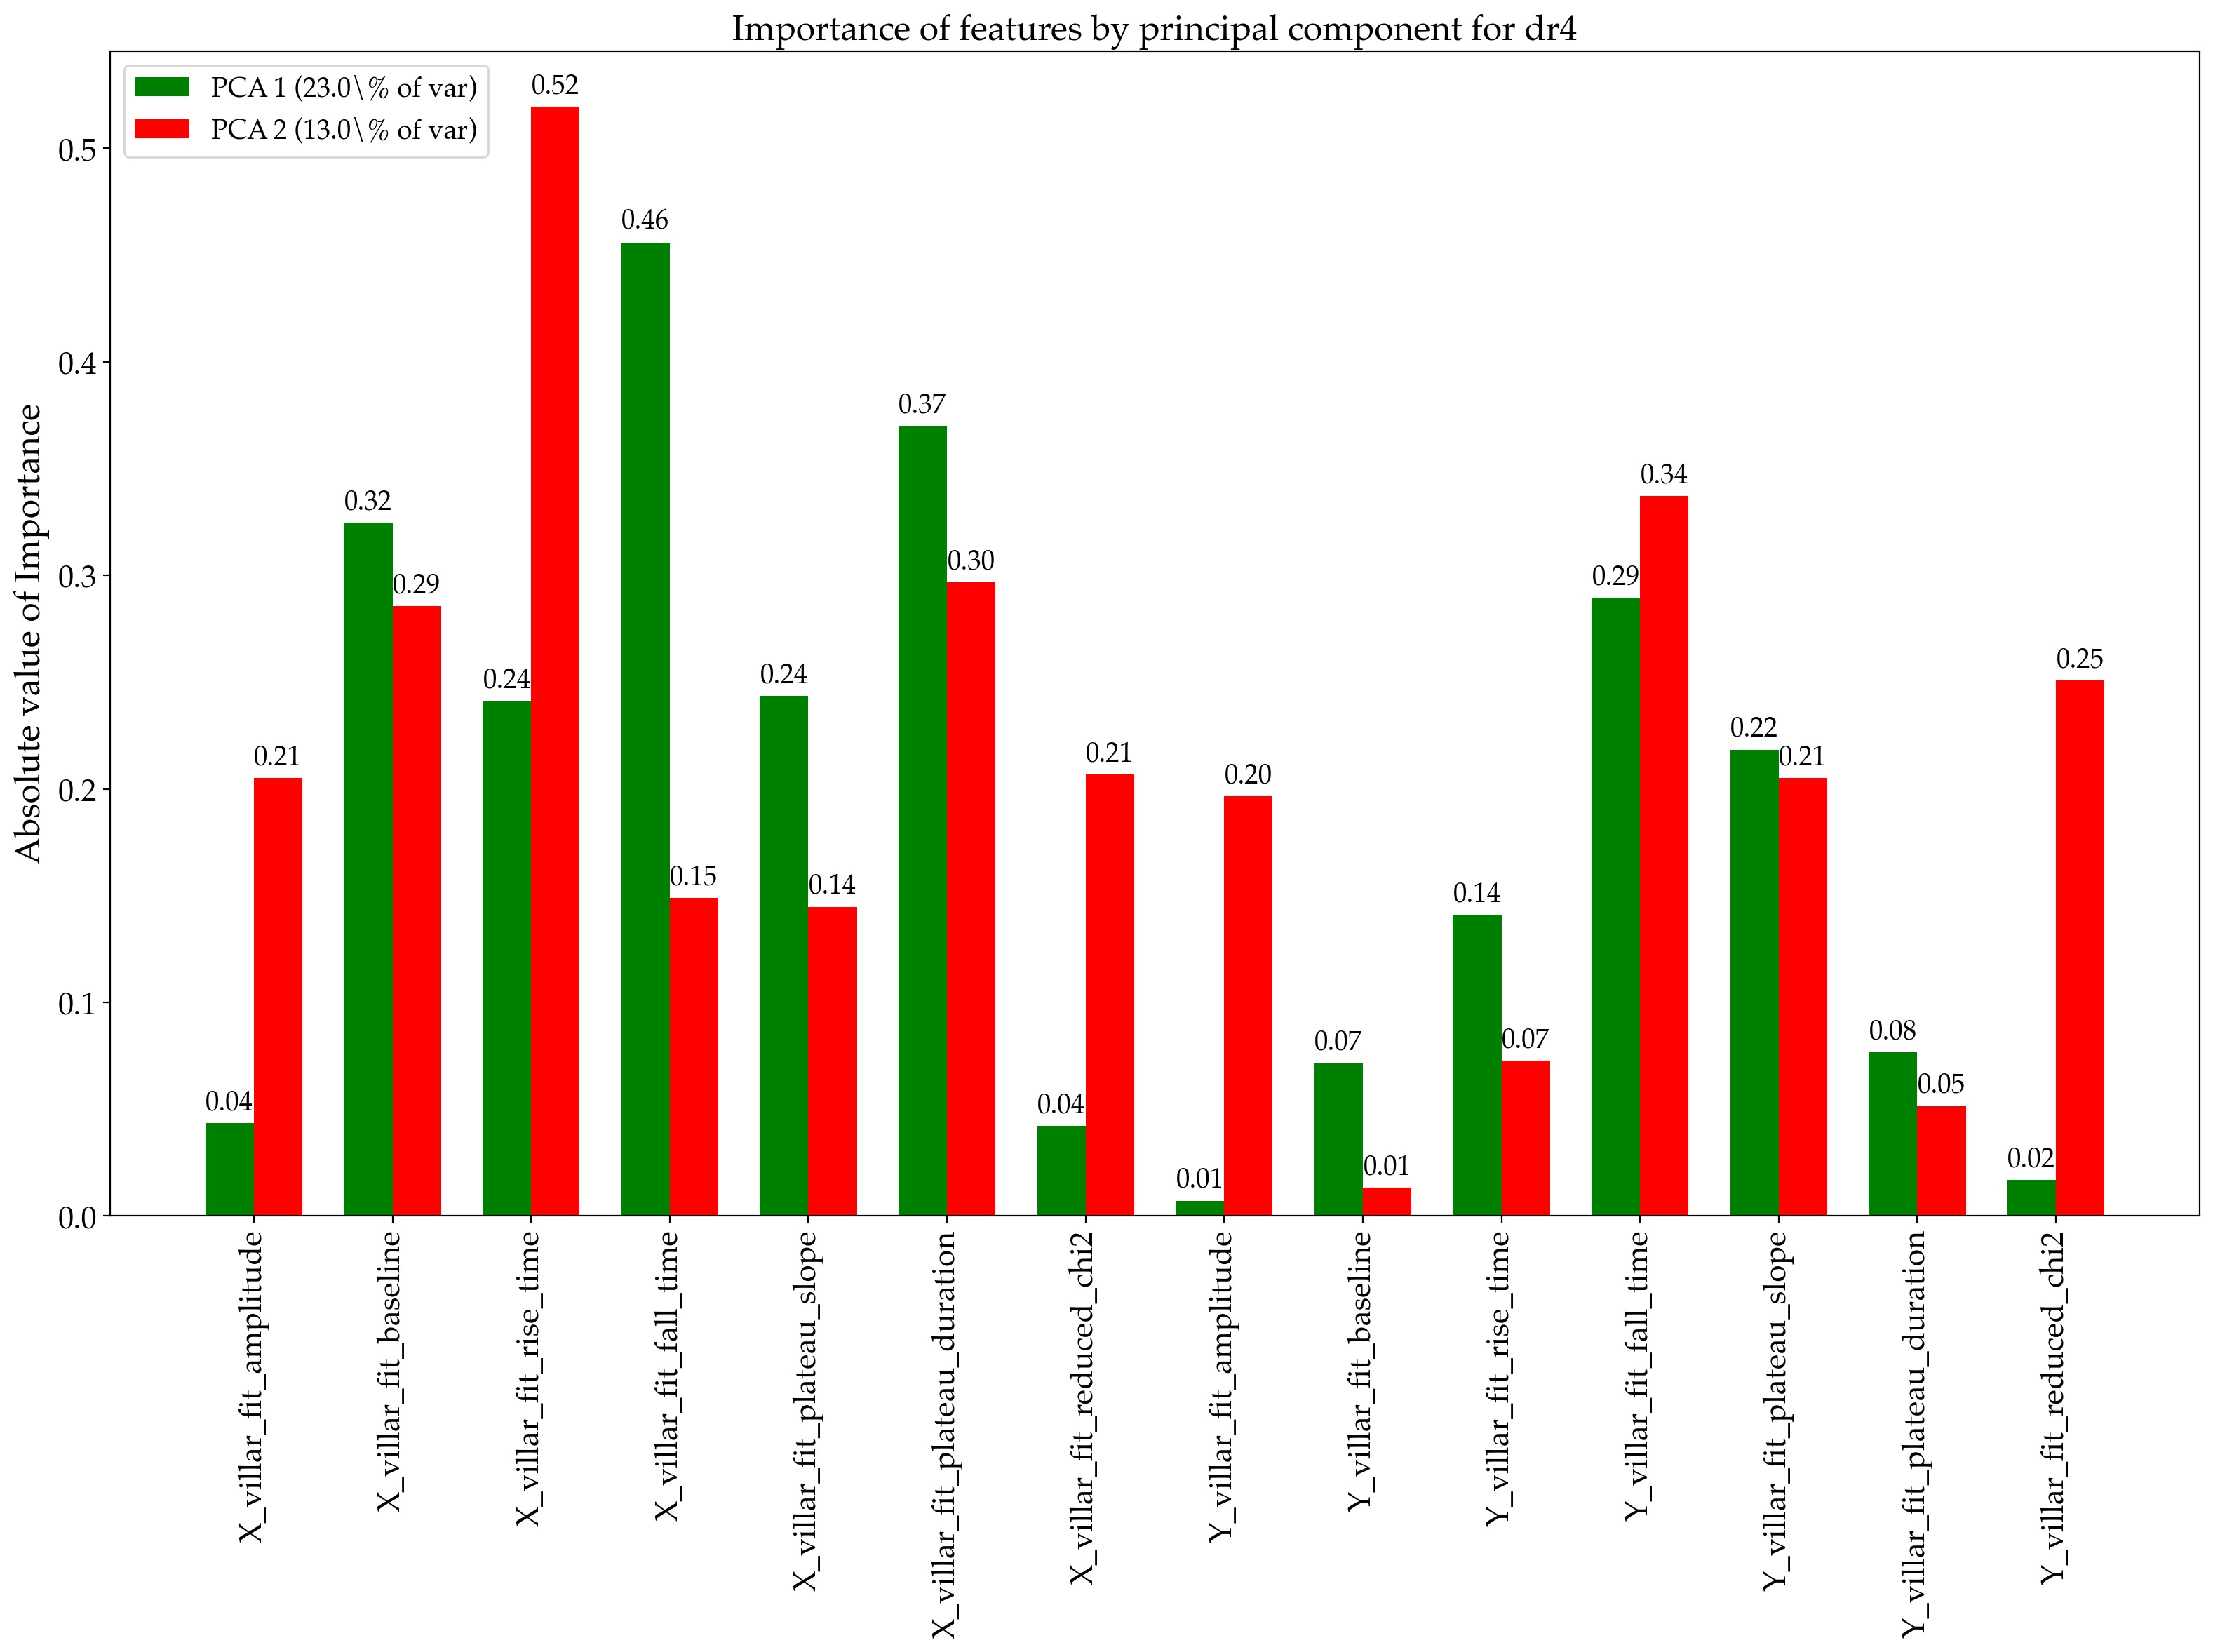

In [95]:
#Shows what PCA consideres the msot important

#cols_latex_read = [r.replace('_', '\_') for r in dr4_df.columns.values]
labels = dr4_df.columns.values
pca1 = abs(np.array(pca_comp.loc[['PCA1']])[0])
pca2 = abs(np.array(pca_comp.loc[['PCA2']])[0])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 12))
rects1 = ax.bar(x - width/2, pca1, width, label=f'PCA 1 ({round(pca_var_ratio[0], 2)*100}\% of var)', color='g')
rects2 = ax.bar(x + width/2, pca2, width, label=f'PCA 2 ({round(pca_var_ratio[1], 2)*100}\% of var)', color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Absolute value of Importance')
ax.set_title('Importance of features by principal component for dr4')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
#ax.set_ylim(0, 0.55)
ax.legend(loc='upper left')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
#plt.savefig('./figures/pca_feat_importance_barchart.png', dpi=300, bbox_inches='tight')

# Repeat kdtree experiment w/ first 8 PCs (of all 14 features) as input

In [96]:
pcs2_X_fake = pd.DataFrame(data=pcs2_X_fake.T, index=fakes_df.index)
pcs2_X_fake

,0,1,2,3,4,5,6,7
ObjectID,,,,,,,,
_4877922_SNIa,-0.020762,0.125595,-0.134331,-0.117749,0.113793,0.013379,0.056420,0.059006
_1309355_SNIa,-1.454188,-4.027442,0.760112,-1.633171,1.043100,-1.261553,1.791835,-1.334184
_3053534_SNIa,-0.017218,0.139978,-0.162730,-0.178060,0.084777,0.009440,0.026037,0.017697
_3315509_SNIa,0.081404,0.078520,0.168921,-0.430607,-0.461843,-0.086817,-0.716069,-0.655310
_4109434_SNIa,-0.079164,0.168244,-0.120798,-0.087947,0.154979,0.012695,-0.000519,-0.012081
...,...,...,...,...,...,...,...,...
_2303364_SNIa,-0.050713,0.064804,0.061714,0.111999,0.086493,-0.037553,-0.015131,0.051276
_4431841_SNIa,-0.040773,0.151373,-0.122444,-0.151517,0.084780,-0.007288,-0.041234,-0.042559
_3414162_SNIa,-0.019558,0.130759,-0.153990,-0.141289,0.105047,0.017495,0.061591,0.056473


In [97]:
pcs2_X_real = pd.DataFrame(data=pcs2_X_real.T, index=dr4_df.index)
pcs2_X_real

,0,1,2,3,4,5,6,7
ObjectID,,,,,,,,
2019pmd,-0.661355,0.682999,-0.038573,0.036311,0.083850,0.537609,-0.061232,-0.749922
2019tvv,-0.028643,0.235158,-0.039247,0.112811,-0.409341,-1.013545,-0.124211,-0.042103
2019wka,-0.060315,0.135189,-0.306615,-0.234033,1.097689,0.912074,-0.022112,0.033813
2019wqf,-0.208945,0.274469,-0.234394,-0.209132,1.216633,1.263971,0.036298,-0.171352
2019wyp,1.107092,-0.597354,-0.267911,-1.066945,-1.929740,-0.251748,0.655303,0.687960
...,...,...,...,...,...,...,...,...
2021xjh,0.244416,0.043973,-0.440969,-0.432429,0.966170,0.299182,-0.014739,0.244978
2021xkm,0.042274,0.254152,-0.340093,-0.330797,-0.386241,-0.695259,-0.094817,-0.084031
2021yab,-0.756672,0.872959,-0.210862,-0.105212,-0.223397,0.127915,-0.099904,-0.907692


In [98]:
pcs2_X_fake.T.shape

(8, 19004)

In [99]:
%%time

# # Reorder SIMIDs to order I want --> Ignore
# fakes_mining_sids = ['6439074373', '9020928999', '6011793767', '4229763628', '6417979422', '6031286883', '604029941']
# fakes_mining_sids_int = list(map(int, fakes_mining_sids))

# pcs_X_fakes_df = pcs_X_fakes_df.reindex(fakes_mining_sids_int)

# KDTREE
#Create a kdtree --> k dimensional binary tree & "plot" all the objects with their 8 dimension
from scipy.spatial import cKDTree

X = np.vstack(pcs2_X_real_df.values)
kdtree = cKDTree(np.vstack(pcs2_X_fake_df.values))
ktot=8
dist, ind = kdtree.query(X, k=ktot)

# Save PCA kdtree as pickle
#pickle.dump(kdtree,open('./pca_15pcs_orig_kdtree.p','wb'))

CPU times: user 34.5 ms, sys: 9.62 ms, total: 44.1 ms
Wall time: 76.9 ms


In [100]:
#Make df that matches the nearest neighbor 1 - 8 from real data to sim
kdtree_results_df = pd.DataFrame()
kdtree_results_df['sid'] = pcs2_X_real.index
kdtree_results_df = kdtree_results_df.set_index('sid')

kdtree_dist_df = kdtree_results_df.copy()

for knn in range(0,ktot):    
    fakes_match_oid, fakes_match_dist = [],[]
    for ix, dis in zip(ind[:, knn], dist[:, knn]):
        fakes_match_oid.append(fakes_df.iloc[ix].name)
        fakes_match_dist.append(dis)
    kdtree_results_df[f'knn={knn+1}_match_OID'] = fakes_match_oid
    kdtree_dist_df[f'knn={knn+1}_dist'] = fakes_match_dist

In [101]:
kdtree_results_df = kdtree_results_df
#kdtree_results_df.to_csv("../Tables/real_data_matched_SNIA_sims_titles.csv.gzip", compression='gzip')
kdtree_results_df

,knn=1_match_OID,knn=2_match_OID,knn=3_match_OID,knn=4_match_OID,knn=5_match_OID,knn=6_match_OID,knn=7_match_OID,knn=8_match_OID
sid,,,,,,,,
2019pmd,_3949852_SNIa,_4927027_SNIa,_3036113_SNIa,_3271002_SNIa,_493763_SNIa,_4192542_SNIa,_1378862_SNIa,_2029431_SNIa
2019tvv,_4346864_SNIa,_1501104_SNIa,_828340_SNIa,_3033272_SNIa,_3746303_SNIa,_3556062_SNIa,_4262059_SNIa,_889664_SNIa
2019wka,_4162106_SNIa,_3229511_SNIa,_2095322_SNIa,_350056_SNIa,_838567_SNIa,_3960991_SNIa,_3910423_SNIa,_5055790_SNIa
2019wqf,_3612474_SNIa,_1378862_SNIa,_4162106_SNIa,_1025883_SNIa,_3036113_SNIa,_3949852_SNIa,_3229511_SNIa,_3271002_SNIa
2019wyp,_3874467_SNIa,_4183383_SNIa,_1592506_SNIa,_2708149_SNIa,_4834854_SNIa,_390780_SNIa,_3792086_SNIa,_4555227_SNIa
...,...,...,...,...,...,...,...,...
2021xjh,_3229511_SNIa,_5055790_SNIa,_2095322_SNIa,_350056_SNIa,_3189703_SNIa,_3066288_SNIa,_3960991_SNIa,_2180213_SNIa
2021xkm,_2510859_SNIa,_3593519_SNIa,_2476110_SNIa,_694931_SNIa,_3178672_SNIa,_4811745_SNIa,_3486865_SNIa,_4293048_SNIa
2021yab,_2563646_SNIa,_3671787_SNIa,_3949852_SNIa,_3271002_SNIa,_4464467_SNIa,_4133409_SNIa,_4018726_SNIa,_3036113_SNIa


In [102]:
kdtree_dist_df = kdtree_dist_df
#kdtree_dist_df.to_csv("../Tables/real_data_matched_SNIA_sims_distances.csv.gzip", compression='gzip')
# kdtree_dist_df.loc["2021xjh"]
kdtree_dist_df


,knn=1_dist,knn=2_dist,knn=3_dist,knn=4_dist,knn=5_dist,knn=6_dist,knn=7_dist,knn=8_dist
sid,,,,,,,,
2019pmd,0.803780,0.826135,0.826649,0.833505,0.838296,0.876318,0.881061,0.896619
2019tvv,1.001068,1.025027,1.026614,1.028608,1.030076,1.030094,1.031105,1.033172
2019wka,0.743362,0.785856,0.802053,0.806918,0.831969,0.843424,0.858749,0.876027
2019wqf,0.946795,0.950122,0.974334,1.088551,1.175209,1.182997,1.232030,1.234133
2019wyp,0.752336,0.885349,0.938246,1.096450,1.112557,1.120222,1.125957,1.135695
...,...,...,...,...,...,...,...,...
2021xjh,0.502178,0.511564,0.533444,0.561589,0.572413,0.573349,0.587731,0.612626
2021xkm,0.803349,0.805770,0.808126,0.808519,0.809711,0.809717,0.809932,0.810200
2021yab,1.153307,1.196051,1.225044,1.226168,1.232566,1.237877,1.242417,1.248974


In [103]:
# Print out row in which sid = 2021mwb
kdtree_dist_df.loc["2021mwb"]

knn=1_dist    0.756593
knn=2_dist    0.916674
knn=3_dist    0.932075
knn=4_dist    0.932189
knn=5_dist    0.955366
knn=6_dist    0.960331
knn=7_dist    0.961713
knn=8_dist    0.985899
Name: 2021mwb, dtype: float64

In [104]:
# Find sid object with the smallest value for knn=1_dist
kdtree_dist_df.loc[kdtree_dist_df['knn=1_dist'].idxmin()]

knn=1_dist    0.316745
knn=2_dist    0.327571
knn=3_dist    0.334833
knn=4_dist    0.364888
knn=5_dist    0.365514
knn=6_dist    0.387076
knn=7_dist    0.388585
knn=8_dist    0.404628
Name: 2020svo, dtype: float64

In [105]:
# Total real objects matched
print("Total real objects matched:", len(np.hstack(kdtree_results_df.values)))

# Of above, total UNIQUE real objects matched
print("Total real UNIQUE objects matched:", len(np.unique(np.hstack(kdtree_results_df.values))))
print(np.unique(np.hstack(kdtree_results_df.values)))

Total real objects matched: 1568
Total real UNIQUE objects matched: 575
['_1024552_SNIa' '_1025883_SNIa' '_1048833_SNIa' '_1050751_SNIa'
 '_1065570_SNIa' '_1071222_SNIa' '_1079603_SNIa' '_1091061_SNIa'
 '_1106133_SNIa' '_1126529_SNIa' '_1129811_SNIa' '_1138860_SNIa'
 '_1139212_SNIa' '_1148538_SNIa' '_1149472_SNIa' '_115215_SNIa'
 '_115851_SNIa' '_1175655_SNIa' '_1197752_SNIa' '_1200531_SNIa'
 '_121380_SNIa' '_1216042_SNIa' '_1225411_SNIa' '_124639_SNIa'
 '_126495_SNIa' '_1286676_SNIa' '_1319381_SNIa' '_1320022_SNIa'
 '_1349684_SNIa' '_1369114_SNIa' '_1378862_SNIa' '_1379955_SNIa'
 '_1383783_SNIa' '_1392886_SNIa' '_1405314_SNIa' '_1407230_SNIa'
 '_1407260_SNIa' '_1425018_SNIa' '_1437769_SNIa' '_1441302_SNIa'
 '_1441787_SNIa' '_1443179_SNIa' '_1450504_SNIa' '_1451253_SNIa'
 '_1455998_SNIa' '_1491844_SNIa' '_1496065_SNIa' '_1498215_SNIa'
 '_1501104_SNIa' '_1512793_SNIa' '_1522292_SNIa' '_1523613_SNIa'
 '_1545759_SNIa' '_1548033_SNIa' '_1568402_SNIa' '_1589864_SNIa'
 '_1592506_SNIa' '_1600

# Visually inspect closest matches here!

Plan of what to do
1. Define functions to get Real Data and Sim Data
2. Once you have the data, replace MJD w/ days from peak
3. Plot side by side 

In [106]:
def read_snana_fits(dir_path):
    snid_list = []
    meta_list = []
    yse_ztf_fp_df_list = []
    meta = {}
    objid = ""
    if (dir_path == "../Retrain_RAPID/for_YSE/data/PALEO_YSE_MODEL43_CCSNe_V19_yselc_v2_52LCs"):
        objid = "yselc_v2"
    #THIS IS SOMETHING THAT WE WILL NEED TO CHANGE
    elif (dir_path == "../../YSE_DR1_SIMS_60k_SNR4_grizXY_SIMLIB_FLUXCALERR_COR_220427/PALEO_YSE_ZTF_MODEL01"): #WILL NEED TO UPDATE FOR LOCAL MACHINE
        objid = "SNIa" #Update if not SN Ia
        
    
    
    heads = sorted(glob.glob(os.path.join(dir_path, '*_HEAD.FITS.gz')))
    phots = sorted(glob.glob(os.path.join(dir_path, '*_PHOT.FITS.gz')))
    assert len(heads) != 0, 'no *_HEAD_FITS.gz are found'
    assert len(heads) == len(phots), 'there are different number of HEAD and PHOT files'
    
    for head, phot in zip(heads, phots): #lots of LCs per head, phot files, so do a few to start
        i = head.find('_HEAD.FITS.gz')
        assert head[:i] == phot[:i], f'HEAD and PHOT files name mismatch: {head}, {phot}'
        filename = head[:i].split('/')[-1].split('.')[0]
        head_title = head[88:92] 
        
        for LCnum, lc in enumerate(sncosmo.read_snana_fits(head, phot)): # remember: multiple SN in single HEAD/PHOT file
            #print(lc.meta)
            lc.meta['redshift'] = lc.meta['SIM_REDSHIFT_HOST']
            redshift = lc.meta['redshift']
            mwebv_data = lc.meta['MWEBV']
            salt_mB = lc.meta['SIM_SALT2mB']
            salt_x1 = lc.meta['SIM_SALT2x1']
            salt_c = lc.meta['SIM_SALT2c']
            checkSnid = lc.meta['SNID']
            checkSnid = checkSnid.decode('UTF-8')
        

            
            redshift = np.round(redshift, 2)
            
            
            ra = lc.meta['RA']
            dec = lc.meta['DEC']
            lc.keep_columns(['MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR', 'PHOTFLAG'])
            totalResidual = 0
            fitNew = []
            # Astropy Table --> Pandas df
            df = lc.to_pandas()
            df = df.rename(columns={
                "BAND": "PASSBAND", 
                "FLUXCAL": "FLUX",
                "FLUXCALERR": "FLUXERR", 
                "PHOTFLAG": "PHOTFLAG"
            })
            
            df['PASSBAND']= df['PASSBAND'].str.decode("utf-8") # turn Bytes into str
            snr = []
            snr = df['FLUX']/df['FLUXERR'] 
            df['MAG'] = np.array(-2.5*np.log10(np.abs(df['FLUX'])))+27.5
            magerr = []
            magerr = 1.086/snr
            df['MAGERR'] = magerr
            #Made DF and have all the info
            meta['object_id'] = objid
            meta['RA'] = ra
            meta['DEC'] = dec
            meta['redshift'] = redshift
            meta['SNID'] = checkSnid
            meta['Head'] = head_title
            meta['MWEBV'] = mwebv_data
            meta['mB'] = salt_mB
            meta['x1'] = salt_x1
            meta['c'] = salt_c
            snid_list.append(objid)
            meta_copy = meta.copy()
            meta_list.append(meta_copy)
            yse_ztf_fp_df_list.append(df)
#             meta.clear()
            
    return snid_list, meta_list, yse_ztf_fp_df_list

In [107]:
#Get cur dir
cur_dir = os.getcwd()
cur_dir

'/Users/sammysharief/Downloads/PGM-Project/Notebooks'

In [108]:
#Get all the data for the respective type --> Real
snid_list_real, meta_list_real, yse_ztf_fp_df_list_real = read_YSE_ZTF_snana_dir(dir_name='spec_yse_dr1') 


Reading YSE+ZTF SNANA-style data files from directory:  spec_yse_dr1


In [131]:
len(snid_list_real)

441

In [130]:
len(meta_list_real)

441

In [132]:
len(yse_ztf_fp_df_list_real)

441

This is too big to be on Github so ask Sammy where he put the data
- As of 21/11/2023 @ 4:18pm I have not put it anywhere. I will link in here the DropBox link I will use

In [110]:
#Get all the data for the respective type --> Sim WILL NEED TO CHANGE FOR LOCAL MACHINE
snid_list_sim, meta_list_sim, sim_df_list_sim = read_snana_fits(dir_path='../../YSE_DR1_SIMS_60k_SNR4_grizXY_SIMLIB_FLUXCALERR_COR_220427/PALEO_YSE_ZTF_MODEL01')


/Users/sammysharief/anaconda3/envs/pgm_project/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sammysharief/anaconda3/envs/pgm_project/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sammysharief/anaconda3/envs/pgm_project/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sammysharief/anaconda3/envs/pgm_project/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sammysharief/anaconda3/envs/pgm_project/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1

In [111]:
print(snid_list_real[0])

print(meta_list_real[0])

print(yse_ztf_fp_df_list_real[0])

2019lbi
{'object_id': '2019lbi', 'original_object_id': '2019lbi', 'ra': 190.088004, 'dec': 1.273998, 'mwebv': 0.015, 'redshift': 0.013, 'peakmjd': 58676.172, 'host_logmass': -99.0, 'peak_abs_mag': -16.708, 'transient_spec_class': 'SNII', 'spectype_3class': 'SNII', 'parsnip_pred_class': 'SNIa', 'parsnip_pred_conf': '43.6', 'parsnip_s1': -0.063, 'parsnip_s1_err': 0.127, 'parsnip_s2': 0.761, 'parsnip_s2_err': 0.272, 'parsnip_s3': -0.109, 'parsnip_s3_err': 0.123, 'superraenn_pred_class': 'SNII', 'superraenn_pred_conf': '70.6', 'ztf_zeropoint': 27.5, 'peakSNR': 61.164, 'max_mjd_gap': 23.018, 'nobs_before_peak': 0, 'nobs_to_peak': 1, 'nobs_after_peak': 63, 'peakmag': 17.042, 'peakflt': 'X', 'passbands': 'YrigXz', 'num_points': 64}
          MJD PASSBAND       FLUX  FLUXERR     MAG  MAGERR PHOTFLAG
0   58676.172        X  15240.973  258.852  17.042   0.018     0x00
1   58676.192        Y  14246.757  232.926  17.116   0.018     0x00
2   58679.187        X  14460.171  311.803  17.100   0.023   

In [112]:
print(snid_list_sim[0])

print(meta_list_sim[0])

print(sim_df_list_sim[0])

SNIa
{'object_id': 'SNIa', 'RA': 49.599161, 'DEC': -1.930453, 'redshift': 0.02, 'SNID': '4734888', 'Head': 'LEO_', 'MWEBV': 0.07340531, 'mB': 15.7407255, 'x1': -1.2377651, 'c': -0.011140285}
          MJD PASSBAND  PHOTFLAG          FLUX     FLUXERR        MAG  \
0   58756.419       X          0    -10.528734   44.831745  24.944059   
1   58763.412       X          0    -80.761421   53.039696  22.731991   
2   58766.420       X          0     17.137049   74.790634  24.415159   
3   58766.487       Y          0   -126.183762   67.351875  22.247492   
4   58769.418       Y          0    -48.586216  112.759346  23.283718   
5   58769.481       X          0   -232.054764  215.911423  21.586023   
6   58778.296       X          0    -14.618416  103.481186  24.587749   
7   58778.380       Y          0    -20.025635   90.850075  24.246035   
8   58781.393       X          0    159.202240   99.588936  21.995127   
9   58784.378       Y          0     32.886307  108.179489  23.707462   
10  58

In [134]:
'''
2021wfn
2020sag
2020yhn
2021itd issue 
2021kyp
2021mfy
2021mwb
'''
real_object_name = "2021mwb"
sims_object_first_name = kdtree_results_df.loc[real_object_name][0] #The first object
print(sims_object_first_name)
sims_object_second_name = kdtree_results_df.loc[real_object_name][1] #The second object
print(sims_object_second_name)
sims_object_third_name = kdtree_results_df.loc[real_object_name][2] #The third object
print(sims_object_third_name)

_4162106_SNIa
_3229511_SNIa
_2095322_SNIa


/var/folders/jv/k_v96nss5g52chcq2phrbl240000gn/T/ipykernel_23690/747770734.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sims_object_first_name = kdtree_results_df.loc[real_object_name][0] #The first object
/var/folders/jv/k_v96nss5g52chcq2phrbl240000gn/T/ipykernel_23690/747770734.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sims_object_second_name = kdtree_results_df.loc[real_object_name][1] #The second object
/var/folders/jv/k_v96nss5g52chcq2phrbl240000gn/T/ipykernel_23690/747770734.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wi

In [135]:
real_villar_fit = []
sim_villar_fit = []
for col in dr4_df.columns:
    real_villar_fit.append(np.round(dr4_df[dr4_df.index == real_object_name][col].values[0],2))
    sim_villar_fit.append(np.round(fakes_df[fakes_df.index == sims_object_first_name][col].values[0] , 2))
    print(col, dr4_df[dr4_df.index == real_object_name][col].values[0])
    print(col, fakes_df[fakes_df.index == sims_object_first_name][col].values[0])
    print()
print(real_villar_fit)
print(sim_villar_fit)
     

X_villar_fit_amplitude 15853.860391139584
X_villar_fit_amplitude 121084.2978995214

X_villar_fit_baseline 572.4181903212243
X_villar_fit_baseline 1418.3882761403838

X_villar_fit_rise_time 1.9208926228001657
X_villar_fit_rise_time 2.3445789562005412

X_villar_fit_fall_time 11.365263366129517
X_villar_fit_fall_time 12.858518159839656

X_villar_fit_plateau_slope 0.1347549047327678
X_villar_fit_plateau_slope -80824.79769391999

X_villar_fit_plateau_duration 15.184880487428156
X_villar_fit_plateau_duration 5.764817344959486e-16

X_villar_fit_reduced_chi2 9.162702577025296
X_villar_fit_reduced_chi2 55.498448316709165

Y_villar_fit_amplitude 13775.561031703017
Y_villar_fit_amplitude 98531.046209302

Y_villar_fit_baseline 84.55207943360256
Y_villar_fit_baseline -384.6873681513098

Y_villar_fit_rise_time 2.3807327886936807
Y_villar_fit_rise_time 1.9857216207520676

Y_villar_fit_fall_time 28.73516048047867
Y_villar_fit_fall_time 26.419745877264607

Y_villar_fit_plateau_slope 2.2417527577589524e

# THIS MAKES HISTOGRAMS 

In [136]:
fig = plt.figure(figsize=(14, 20))
i = 0
with PdfPages(f'Villar_Bazin_{real_object_name}_fit_param_hists.pdf') as pdf:
    for col in dr4_df.columns:
        ax = fig.add_subplot(9, 4, i+1) #42 features
        i = i + 1
        combined = np.append(dr4_df[col].values, fakes_df[col].values)
       
        value = np.abs(dr4_df[dr4_df.index == real_object_name][col].values[0])
        
        if ( value >= 0 and value < 1):
            data_real = np.abs(dr4_df[col])
            _, bins_real = np.histogram(np.log10(data_real + .1), bins=20)
            data_sim = np.abs(fakes_df[col])
            _, bins_sim = np.histogram(np.log10(data_sim + .1), bins=20)
            combined = np.abs(combined)
            _, bin_combined = np.histogram(np.log10(combined + .1), bins=20)
        else:
            data_real = np.abs(dr4_df[col])
            _, bins_real = np.histogram(np.log10(data_real + 1), bins=20)
            data_sim = np.abs(fakes_df[col])
            _, bins_sim = np.histogram(np.log10(data_sim + 1), bins=20)
            combined = np.abs(combined)
            _, bin_combined = np.histogram(np.log10(combined + 1), bins=20)

        
        plt.hist(data_sim, bins=4**bin_combined, color = 'g', label = 'Sim. Sample', density = True, alpha = 0.4)
        plt.hist(data_real, bins=4**bin_combined, color = 'b', label = 'YSE DR1', density = True, alpha = 0.4)
        
        real = round(float(np.abs(data_real[data_real.index == real_object_name])), 2)
        first = round(float(np.abs(data_sim[data_sim.index == sims_object_first_name])), 2)
        second = round(float(np.abs(data_sim[data_sim.index == sims_object_second_name])), 2)
        third = round(float(np.abs(data_sim[data_sim.index == sims_object_third_name])), 2)
        plt.axvline(real, alpha = 1, color = 'r', linewidth = 3, label = real_object_name)

        plt.axvline(first, alpha = 0.7, linestyle = '--', color = 'orange', linewidth = 3, label = sims_object_first_name)
        
        plt.axvline(second, alpha = 0.7, linestyle = '--', color = 'pink', linewidth = 3, label = sims_object_second_name)
        
        plt.axvline(third, alpha = 0.7, linestyle = '--', color = 'cyan', linewidth = 3, label = sims_object_third_name)

        plt.yscale('log')
        plt.gca().set_xscale("log")
        mean = np.round(np.mean(combined), 2)
        median = np.round(np.median(combined), 2)
        stdev = np.round(st.pstdev(combined), 2)
        
        #IF ANY OF THESE ARE MUCH SMALLER THAN 10^-1 JUST MAKE IT 10^-1 
        real_object_valye = np.abs(dr4_df[dr4_df.index == real_object_name][col].values[0])
        real_object_valye = np.round(real_object_valye, 2)
        if (real_object_valye < 10e-1):
            real_object_valye = 10e-1
            plt.axvline(real_object_valye, alpha = 1, color = 'r', linewidth = 3, label = real_object_name)

        fake_object_first_valye = np.abs(fakes_df[fakes_df.index == sims_object_first_name][col].values[0])
        fake_object_first_valye = np.round(fake_object_first_valye, 2)
        if (fake_object_first_valye < 10e-1):
            fake_object_first_valye = 10e-1
            plt.axvline(fake_object_first_valye, linestyle = '--', alpha = 0.7, color = 'orange', linewidth = 3, label = sims_object_first_name)

        fake_object_second_valye = np.abs(fakes_df[fakes_df.index == sims_object_second_name][col].values[0])
        fake_object_second_valye = np.round(fake_object_second_valye, 2)
        if (fake_object_second_valye < 10e-1):
            fake_object_second_valye = 10e-1
            plt.axvline(fake_object_second_valye, linestyle = '--', alpha = 0.7, color = 'pink', linewidth = 3, label = sims_object_second_name)

        fake_object_third_valye = np.abs(fakes_df[fakes_df.index == sims_object_third_name][col].values[0])
        fake_object_third_valye = np.round(fake_object_third_valye, 2)
        if (fake_object_third_valye < 10e-1):
            fake_object_third_valye = 10e-1
            plt.axvline(fake_object_third_valye, linestyle = '--', alpha = 0.7, color = 'cyan', linewidth = 3, label = sims_object_third_name)
        real_sigma = np.round(np.abs(real_object_valye - mean)/stdev, 4)

        sim_first_sigma = np.round(np.abs(fake_object_first_valye - mean)/stdev, 4)

        sim_second_sigma = np.round(np.abs(fake_object_second_valye - mean)/stdev, 4)

        sim_third_sigma = np.round(np.abs(fake_object_third_valye - mean)/stdev, 4)
        if (col ==  'X_villar_fit_amplitude'):
            plt.xlim(4e2, 2.3e4)
        elif(col ==  'X_villar_fit_baseline'):
            plt.xlim(8, 1e4)
        if(col ==  'X_villar_fit_rise_time'):
            plt.xlim(0.9, 5e2)
        elif(col ==  'X_villar_fit_fall_time'):
            plt.xlim(0.9, 6e4)
        elif(col ==  'X_villar_fit_plateau_slope'):
            plt.xlim(1.5, 2e4)
        elif(col ==  'X_villar_fit_plateau_duration'):
            plt.xlim(0.9, 2e2)
        elif(col == 'X_villar_fit_reduced_chi2'):
            plt.xlim(0.9, 5e2)
        elif (col == 'Y_villar_fit_amplitude'):
            plt.xlim(1e2, 2e4)
        elif (col == 'Y_villar_fit_baseline'):
            plt.xlim(0.9, 1e4)
        elif (col == 'Y_villar_fit_rise_time'):
            plt.xlim(0.9, 3e3)
        elif (col == 'Y_villar_fit_fall_time'):
            plt.xlim(1, 1e8)
        elif(col ==  'Y_villar_fit_plateau_slope'):
            plt.xlim(0.5, 1e4)
#         elif(col == 'Y_villar_fit_plateau_duration'):
#             plt.xlim(min_xvalue, max_xvalue)
        elif(col == 'Y_villar_fit_reduced_chi2'):
            plt.xlim(1, 1e2)
        if (col[0] == 'X'):
            xlabel = 'ZTF-g_' + col[13:]
            col = 'ZTF-g_' + col[13:]
        else:
            xlabel = 'ZTF-r_' + col[13:]
            col = 'ZTF-r_' + col[13:]
        plt.xlabel(xlabel)
        if (i == 5):
            plt.ylabel('Normalized Number of Objects', loc = 'top', labelpad = 30, fontsize = 20) # of Objects  
    plt.tight_layout()
    plt.legend(loc='lower right', bbox_to_anchor=(3.5, 0.5), ncol=3, fancybox=True, shadow=True)
    pdf.savefig(bbox_inches='tight')
    plt.close()


/var/folders/jv/k_v96nss5g52chcq2phrbl240000gn/T/ipykernel_23690/983152607.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  real = round(float(np.abs(data_real[data_real.index == real_object_name])), 2)
/var/folders/jv/k_v96nss5g52chcq2phrbl240000gn/T/ipykernel_23690/983152607.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  first = round(float(np.abs(data_sim[data_sim.index == sims_object_first_name])), 2)
/var/folders/jv/k_v96nss5g52chcq2phrbl240000gn/T/ipykernel_23690/983152607.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  second = round(float(np.abs(data_sim[data_sim.index == sims_object_second_name])), 2)
/var/folders/jv/k_v96nss5g52chcq2phrbl240000gn/T/ipykernel_23690/98315

# THIS MAKES LIGHT CURVE

In [137]:
'''
Given:
Real Obj Name, Meta_list, df
AND
Sim Obj Name, snid_list, sim df

We know these objects have villar fits so we can skip the check --> Still need residual check 
'''
plt.style.use('fig_publication-villarfit.mplstyle')
def plotNearesrtNeighbors(real_object_name, meta_list, yse_ztf_fp_df_list, sims_object_name, snid_list, meta_listSim, sim_df_list, plotType = "FLUX", thresehold = 0.5):
    mcmc_niter=(4096)
    d_real = {'X': "ZTF-g", 'Y': "ZTF-r", 'g': "PS1-g", 'r': 'PS1-r', 'i': "PS1-i", 'z': "PS1-z"}
    d_sim = {'X ': "ZTF-g", 'Y ': "ZTF-r", 'g ': "PS1-g", 'r ': 'PS1-r', 'i ': "PS1-i", 'z ': "PS1-z"}
    lmsder_niter=64
    fit = VillarFit('mcmc-lmsder', mcmc_niter=mcmc_niter, lmsder_niter=lmsder_niter) #increase mcmc_niter if fits are not good
    df = pd.DataFrame()   
    mebvExist = 0
    num_of_bands = 0
    no_points_to_plot_mag = 0
    no_points_to_plot_flux = 0
    title = ""
    fig = plt.figure(figsize=(14, 5))
    #CHANGE PATH TO BE WHATEVER YOU WANT
    with PdfPages(f'{real_object_name}_Plots.pdf') as pdf:
        for i in range (0, 2):
            ax = fig.add_subplot(1, 2, i+1) #42 features
            if (i == 0):
                plt.ylim(0, 17000)
                #THIS WILL NEED TO CHANGE IF NOT 2021mwb
                mB = 17.23
                x1 = -1.26
                c = -0.06
                title = f'Real_Data_{plotType}'
                df = yse_ztf_fp_df_list #REAL DATA
                mwebv_data =  meta_list['mwebv']
                mwebv_data = np.round(mwebv_data, 2)
                print("REAL")
                print(type(mwebv_data))
                print(mwebv_data)
                df = df.replace({"PASSBAND": d_real})
                objid = f'{real_object_name} (SNIa)'
                D_id_color = {
                    "ZTF-g": u"#b9ac70",
                    "ZTF-r": u"#bd1f01",
                    "PS1-g": u"#4daf4a",
                    "PS1-r": u"#e41a1c",
                    "PS1-i": u"#832db6",
                    "PS1-z": u"#656364"}
            else:
                plt.xlim(-25, 110)
                plt.ylim(0, 17000)
                mB = np.format_float_positional(meta_listSim['mB'], precision=2) 
                x1 = np.format_float_positional(meta_listSim['x1'], precision=2) 
                c = np.format_float_positional( meta_listSim['c'], precision=2) 
                title =  f'{snid_list}_{plotType}_sims'
                df = sim_df_list #SIMS DATA
                df = df.replace({"PASSBAND": d_sim})
                head = meta_listSim['Head']
                mwebv_data = meta_listSim['MWEBV']
                mwebv_data = np.format_float_positional(mwebv_data, precision=2)
                print("Sim")
                print(type(mwebv_data))
                print(mwebv_data)
                uniqueObjId = meta_listSim['SNID']
                objid = f'SIM ID = {sims_object_name[1:len(sims_object_name)-5]} (SNIa)'
                D_id_color = {
                    "ZTF-g": u"#b9ac70",
                    "ZTF-r": u"#bd1f01",
                    "PS1-g": u"#4daf4a",
                    "PS1-r": u"#e41a1c",
                    "PS1-i": u"#832db6",
                    "PS1-z": u"#656364"}

            df = df.reset_index(drop=True)
        
            df['SNR'] = df['FLUX']/df['FLUXERR'] 
            redshift = meta_list['redshift']
            if (redshift < 0):
                redshift = "N/A"
                
            df2 = df[df['PASSBAND'] == 'ZTF-r']

            peakMJD = df2.loc[df2['FLUX'].idxmax()]['MJD']  
        
            df['MJD'] =  df['MJD'] - peakMJD

            df['PLOTCOLOR'] = df.PASSBAND.map(D_id_color)
            results_pb, models_pb = [], []
            totalResidual = 0
            passband = df['PASSBAND']
            count = 0
            countPlot = 0

            if (plotType == "MAG"):
                plt.gca().invert_yaxis()


            for pb in np.unique(passband):
                
                mask = (df['PASSBAND'] == pb) & (df['PHOTFLAG'] != 0) & (df['SNR'] > 4) & (df['FLUX'] > 0)#no non-detections
                df_pb = df[mask] 
                df_pb = df_pb.sort_values(by=['MJD'], ascending=True) # w/ photpipe, some have (near) duplicate MJDs separated
                df_pb = df_pb.drop_duplicates(subset=['MJD']) # Remove all duplicate MJD rows (prob w/ photpipe output)    
                mjd_pb = np.array(df_pb['MJD'])
                mag_pb = np.array(df_pb['MAG'])
                magerr_pb = np.array(df_pb['MAGERR'])
                flux_pb = np.array(df_pb['FLUX'])
                fluxerr_pb = np.array(df_pb['FLUXERR'])
                passband_pb = np.array(df_pb['PASSBAND'])
                photflag_pb = np.array(df_pb['PHOTFLAG'])
                plotcolor_pb = df_pb['PLOTCOLOR'] 
                if (len(mjd_pb) < 8 and len(mjd_pb) > 0):
                    df_pb.drop(df_pb.index[df_pb['PASSBAND'] == pb], inplace=True)
                    count = count + 1
                    plt.errorbar(mjd_pb, flux_pb, fluxerr_pb, alpha=0.7, fmt='o', c=np.unique(plotcolor_pb)[0], label=pb, ms = 7.5 ,elinewidth = 2)
                    continue
                if (len(mjd_pb) == 0):
                    print(f'This pb: {pb} has no data points')
                    continue
                else:
                    if (pb == "PS1-g" or pb == "PS1-r" or pb == "PS1-i" or pb == "PS1-z"):
                        continue
                    
                    mjd_pb = np.float64(mjd_pb)
                    flux_pb = np.float64(flux_pb)
                    fluxerr_pb = np.float64(fluxerr_pb)
                    result_pb = fit(mjd_pb, flux_pb, fluxerr_pb, sorted=True) #sorted=True now b/c we use sort_value
                    results_pb.append(result_pb)
                    max_mjd_pb = np.max(mjd_pb)
                    min_mjd_pb = np.min(mjd_pb)
                    day0p1 = (max_mjd_pb-min_mjd_pb)/0.1
                    mjd_grid_pb = np.linspace(min_mjd_pb, max_mjd_pb, int(day0p1))
                    # Minimum number of observations: **8** per band to plot
                    model_pb = VillarFit.model(mjd_grid_pb, result_pb)
                    models_pb.append(model_pb)
                    #Villar fit on actual mjd data so you have the same amount of data points
                    model_pbNew = VillarFit.model(mjd_pb, result_pb) #Just using actual data --> It gives it to you in flux
                    model_pbMagNew = np.array(-2.5*np.log10(np.abs(model_pbNew)))+27.5 #Converting to Mag
                    Residuals_pb = np.abs(mag_pb - model_pbMagNew)
                    df_pb['Residuals'] = np.array(Residuals_pb)
                    if not os.path.exists(f'../Photpipe/yse_ztf_fp_VillarFit_noNonDetect_flux_mcmc_niter={mcmc_niter}_lmsder_niter={lmsder_niter}'):
                        os.makedirs(f'../Photpipe/yse_ztf_fp_VillarFit_noNonDetect_flux_mcmc_niter={mcmc_niter}_lmsder_niter={lmsder_niter}')

                    plt.xlabel('Days from ZTF-r band peak')
                    if (plotType == 'FLUX'):
                        if plt.gca().yaxis_inverted():
                            plt.gca().invert_yaxis()
                        #Flux
                        plt.ylabel('FLUX')
                        plt.errorbar(mjd_pb, flux_pb, fluxerr_pb, alpha=0.7, fmt='o', c=np.unique(plotcolor_pb)[0], label=pb, ms = 7.5, elinewidth = 2)
                        plt.plot(mjd_grid_pb, model_pb, linestyle='dashed', 
                             linewidth=2.5, alpha=0.9, c=np.unique(plotcolor_pb)[0], label=f'{pb}-fit')
                    else:
                        #Mag
                        plt.ylabel('MAG')
                        if plt.gca().yaxis_inverted():
                            plt.errorbar(mjd_pb, mag_pb, magerr_pb, alpha=0.7, fmt='o', c=np.unique(plotcolor_pb)[0], label=pb)
                        else:
                            plt.gca().invert_yaxis()
                            plt.errorbar(mjd_pb, mag_pb, magerr_pb, alpha=0.7, fmt='o', c=np.unique(plotcolor_pb)[0], label=pb)
                    if (type(redshift) == str):
                        redshift = "N/A"
                        plt.title(f'{objid}, z={redshift}, mwebv={mwebv_data}, \n SALT $x_1$: {x1}, $c$: {c}, $m_B$: {mB}')
                    else: 
                        redshift <= 0
                        plt.title(f'{objid}, z={str(round(redshift, 3))}, \n SALT $x_1$: {x1}, $c$: {c}, $m_B$: {mB}')
                if (type(redshift) == str):
                    redshift = "N/A"
                    plt.title(f'{objid}, z={redshift}, mwebv={mwebv_data}, \n SALT $x_1$: {x1}, $c$: {c}, $m_B$: {mB}')
                else: 
                    redshift <= 0
                    plt.title(f'{objid}, z={str(round(redshift, 3))}, mwebv={mwebv_data}, \n SALT $x_1$: {x1}, $c$: {c}, $m_B$: {mB}')
            '''
            Rise Time --> ZTF - g
            Ampltiude -->
            ReducedChi --> 
            '''
            #combined = np.append(dr4_df[col].values, fakes_df[col].values)
            amp_combined = np.append(dr4_df['Y_villar_fit_amplitude'].values, fakes_df['Y_villar_fit_amplitude'].values)
            amp_mean = np.round(np.mean(amp_combined), 2)
            amp_median = np.round(np.median(amp_combined), 2)
            amp_stdev = np.round(st.pstdev(amp_combined), 2)

            gamma_combined = np.append(dr4_df['Y_villar_fit_plateau_duration'].values, fakes_df['Y_villar_fit_plateau_duration'].values)
            gamma_combined_mean = np.round(np.mean(gamma_combined), 2)
            gamma_combined_median = np.round(np.median(gamma_combined), 2)
            gamma_combined_stdev = np.round(st.pstdev(gamma_combined), 2)

            rise_combined = np.append(dr4_df['X_villar_fit_rise_time'].values, fakes_df['X_villar_fit_rise_time'].values)
            rise_mean = np.round(np.mean(rise_combined), 2)
            rise_median = np.round(np.median(rise_combined), 2)
            rise_stdev = np.round(st.pstdev(rise_combined), 2)

            chi_combined =  np.append(dr4_df['X_villar_fit_reduced_chi2'].values, fakes_df['X_villar_fit_reduced_chi2'].values)
            chi_mean = np.round(np.mean(chi_combined), 2)
            chi_median = np.round(np.median(chi_combined), 2)
            chi_stdev = np.round(st.pstdev(chi_combined), 2)
            if (i == 0):
                ampltiude_sigma = np.round(np.abs(real_villar_fit[7] - amp_mean)/amp_stdev, 4)
                gamma_sigma = np.round(np.abs(real_villar_fit[12] - gamma_combined_mean)/gamma_combined_stdev, 4)
                rise_sigma = np.round(np.abs(real_villar_fit[2] - rise_mean)/rise_stdev, 4)
                chi_sigma = np.round(np.abs(real_villar_fit[6] - chi_mean)/chi_stdev, 4)
                
                plt.text(46, 16200, f'ZTF-r $A$: {real_villar_fit[7]} ({ampltiude_sigma}$\sigma$)' )
                plt.text(54, 15200, r'ZTF-r $\gamma$: ' + f'{real_villar_fit[12]} ({gamma_sigma}$\sigma$)')
                plt.text(50, 14200, r'ZTF-g $t_{rise}$: ' + f'{real_villar_fit[2]} ({rise_sigma}$\sigma$)')
                plt.text(33, 13200, r'ZTF-g reduced $\chi^2$: ' + f'{real_villar_fit[6]} ({chi_sigma}$\sigma$)')
            else:
                ampltiude_sigma = np.round(np.abs(sim_villar_fit[7] - amp_mean)/amp_stdev, 4)
                gamma_sigma = np.round(np.abs(sim_villar_fit[12] - gamma_combined_mean)/gamma_combined_stdev, 4)
                rise_sigma = np.round(np.abs(sim_villar_fit[2] - rise_mean)/rise_stdev, 4)
                chi_sigma = np.round(np.abs(sim_villar_fit[6] - chi_mean)/chi_stdev, 4)

                plt.text(45, 16200, f'ZTF-r $A$: {sim_villar_fit[7]} ({ampltiude_sigma}$\sigma$)' )
                plt.text(53.5, 15200, r'ZTF-r $\gamma$: ' + f'{sim_villar_fit[12]} ({gamma_sigma}$\sigma$)')
                plt.text(49.5, 14200, r'ZTF-g $t_{rise}$: ' + f'{sim_villar_fit[2]} ({rise_sigma}$\sigma$)')
                plt.text(29.5, 13100, r'ZTF-g reduced $\chi^2$: ' + f'{sim_villar_fit[6]} ({chi_sigma}$\sigma$)')

        plt.legend(loc='center right', bbox_to_anchor=(0.65, 1.25), ncol=8, fancybox=False, shadow=False, frameon = False)
        pdf.savefig(bbox_inches='tight')  # saves the current figure into a pdf page
        plt.close()

# Find nearest neighbor, make df, and pass it to function above

real_object_namen --> This corresponds to 2021mwb

meta_list --> Dict w/ len of 1 

yse_ztf_fp_df_list 

sims_object_first_name

snid_list_sim

meta_list_sim

sim_df_list_sim

In [138]:
# sim_df_list_sim = pd.concat(sim_df_list_sim, ignor≈e≈_index=True)
sims_object_first_name[-4:]

'SNIa'

In [139]:
target_object_id = "_4791133_SNIa" #Change this to be flexiable
#Checks to make sure same type of SN
#Get last 4 elements of sims_object_first_name
target_object_id = sims_object_first_name[-4:]
# sims_object_first_name = target_object_id

# Iterate over the list of dictionaries
for meta_dict in meta_list_sim:
    object_id = meta_dict.get('object_id', '')
    if target_object_id in object_id:
        # Found the object_id, do something with it
        print(f"Object_id {target_object_id} found: {object_id}")
        break
else:
    # Executed if the loop completes without a break (i.e., object_id not found)
    print(f"Object_id {target_object_id} not found in meta_list_sim")

Object_id SNIa found: SNIa


In [140]:
meta_list_sim

[{'object_id': 'SNIa',
  'RA': 49.599161,
  'DEC': -1.930453,
  'redshift': 0.02,
  'SNID': '4734888',
  'Head': 'LEO_',
  'MWEBV': 0.07340531,
  'mB': 15.7407255,
  'x1': -1.2377651,
  'c': -0.011140285},
 {'object_id': 'SNIa',
  'RA': 142.706471,
  'DEC': 30.871843,
  'redshift': 0.06,
  'SNID': '4877922',
  'Head': 'LEO_',
  'MWEBV': 0.01879625,
  'mB': 18.296194,
  'x1': 0.7976002,
  'c': 0.214206},
 {'object_id': 'SNIa',
  'RA': 145.192026,
  'DEC': -8.4785,
  'redshift': 0.14,
  'SNID': '644852',
  'Head': 'LEO_',
  'MWEBV': 0.02998067,
  'mB': 20.135353,
  'x1': -2.8609006,
  'c': -0.008877541},
 {'object_id': 'SNIa',
  'RA': 217.500587,
  'DEC': 39.945841,
  'redshift': 0.03,
  'SNID': '1309355',
  'Head': 'LEO_',
  'MWEBV': 0.011072368,
  'mB': 16.886297,
  'x1': -1.3398683,
  'c': 0.09575258},
 {'object_id': 'SNIa',
  'RA': 139.699564,
  'DEC': 30.354678,
  'redshift': 0.1,
  'SNID': '3053534',
  'Head': 'LEO_',
  'MWEBV': 0.017250733,
  'mB': 18.937382,
  'x1': 0.953305,
  '

In [141]:
sims_object_first_name

'_4162106_SNIa'

In [142]:
meta_list_name

'_3036113_SNIa'

In [143]:
#snid_list_real, meta_list_real, yse_ztf_fp_df_list_real
for i in range (0, len(snid_list_real)):
    if (snid_list_real[i] == real_object_name):
        meta_list = meta_list_real[i]
        yse_ztf_fp_df_list = yse_ztf_fp_df_list_real[i]  
        print(f'{snid_list_real[i]} Real Break')      
        break
    
#snid_list_sim, meta_list_sim, sim_df_list_sim   
for i in range (0, len(meta_list_sim)):
    part_one = meta_list_sim[i]['Head']
    part_two = meta_list_sim[i]['SNID']
    part_three = meta_list_sim[i]['object_id']
    print(meta_list_name)
    meta_list_name = '_' + part_two + '_' + part_three
    # print(meta_list_name, sims_object_first_name)
    if (meta_list_name == sims_object_first_name):
        meta_listSim = meta_list_sim[i]
        snid_list = snid_list_sim[i]
        sim_df_list = sim_df_list_sim[i]
        print(f'{meta_list_name} SIM BREAK')
        break
        


2021mwb Real Break
_3036113_SNIa
_4734888_SNIa
_4877922_SNIa
_644852_SNIa
_1309355_SNIa
_3053534_SNIa
_523956_SNIa
_3315509_SNIa
_4109434_SNIa
_3676100_SNIa
_2434434_SNIa
_1474619_SNIa
_4038663_SNIa
_2639896_SNIa
_4754960_SNIa
_2300917_SNIa
_4510347_SNIa
_2688496_SNIa
_3077135_SNIa
_866884_SNIa
_597922_SNIa
_1749652_SNIa
_1671558_SNIa
_2471594_SNIa
_4424922_SNIa
_2773720_SNIa
_3759129_SNIa
_456799_SNIa
_3314815_SNIa
_1584481_SNIa
_1613562_SNIa
_4861356_SNIa
_595150_SNIa
_298498_SNIa
_1897588_SNIa
_5045663_SNIa
_916365_SNIa
_2956902_SNIa
_2350998_SNIa
_1204723_SNIa
_2368604_SNIa
_2982872_SNIa
_863775_SNIa
_3849959_SNIa
_1718563_SNIa
_1742412_SNIa
_2765184_SNIa
_165250_SNIa
_3340806_SNIa
_1224488_SNIa
_4011154_SNIa
_3095131_SNIa
_3542438_SNIa
_3277085_SNIa
_553819_SNIa
_2036258_SNIa
_388362_SNIa
_2489420_SNIa
_2796227_SNIa
_3525167_SNIa
_2062536_SNIa
_3638586_SNIa
_4507054_SNIa
_266707_SNIa
_4428798_SNIa
_4537325_SNIa
_1390141_SNIa
_2405821_SNIa
_358472_SNIa
_4021718_SNIa
_3396879_SNIa
_

In [144]:
print('First closest object: ', sims_object_first_name)
print('Second closest object: ', sims_object_second_name)
print('Third closest object: ', sims_object_third_name)

First closest object:  _4162106_SNIa
Second closest object:  _3229511_SNIa
Third closest object:  _2095322_SNIa


In [145]:
meta_list

{'object_id': '2021mwb',
 'original_object_id': '2021mwb',
 'ra': 242.237984,
 'dec': 35.421083,
 'mwebv': 0.019,
 'redshift': 0.043,
 'peakmjd': 59369.368,
 'host_logmass': -99.0,
 'peak_abs_mag': -19.372,
 'transient_spec_class': 'SNIa',
 'spectype_3class': 'SNIa',
 'parsnip_pred_class': 'SNIa',
 'parsnip_pred_conf': '100.0',
 'parsnip_s1': -0.07,
 'parsnip_s1_err': 0.011,
 'parsnip_s2': 0.331,
 'parsnip_s2_err': 0.03,
 'parsnip_s3': 1.452,
 'parsnip_s3_err': 0.02,
 'superraenn_pred_class': 'SNIa',
 'superraenn_pred_conf': '100.0',
 'ztf_zeropoint': 27.5,
 'peakSNR': 122.188,
 'max_mjd_gap': 3.918,
 'nobs_before_peak': 31,
 'nobs_to_peak': 32,
 'nobs_after_peak': 126,
 'peakmag': 17.024,
 'peakflt': 'X',
 'passbands': 'YrigXz',
 'num_points': 158}

In [146]:
meta_listSim

{'object_id': 'SNIa',
 'RA': 17.645135,
 'DEC': 2.113941,
 'redshift': 0.02,
 'SNID': '4162106',
 'Head': 'LEO_',
 'MWEBV': 0.025656948,
 'mB': 15.240442,
 'x1': 0.11709776,
 'c': 0.046366695}

In [147]:
snid_list

'SNIa'

In [148]:
sim_df_list

,MJD,PASSBAND,PHOTFLAG,FLUX,FLUXERR,MAG,MAGERR
0,59086.396,Y,0,55.872543,70.755623,23.132004,1.375284
1,59086.462,X,0,10.048355,53.629662,24.994762,5.796154
2,59088.417,Y,0,-13.917784,59.555286,24.641075,-4.647079
3,59089.379,X,0,66.297615,42.317326,22.946255,0.693187
4,59090.368,X,0,-0.384874,45.736504,28.536703,-129.054657
...,...,...,...,...,...,...,...
155,59252.156,Y,4096,7619.625488,195.610550,17.795166,0.027880
156,59254.156,Y,4096,6933.431152,262.636810,17.897629,0.041137
157,59254.230,i,4096,5236.087402,157.225723,18.202484,0.032610
158,59254.230,g,4096,4066.857910,181.961334,18.476852,0.048590


In [149]:
plotNearesrtNeighbors(real_object_name, meta_list, yse_ztf_fp_df_list, sims_object_first_name, snid_list, meta_listSim, sim_df_list, plotType = "FLUX", thresehold = 0.5)

REAL
<class 'numpy.float64'>
0.02
Sim
<class 'str'>
0.03


In [129]:
real_object_name

'2020svo'